## Extending HelioLinC to Single Detections
#### Matt Holman, Matt Payne, Ed Lin, Dave Gerdes


## 27 July 2018


The plan is to:

    * Import some libraries.
    * Read in Ed's test data set.
    * Explore that data set.
    * Write routines to do the single detection shift-and-add kind of thing.
    
The goal is to finish what is needed for a quick paper.


### The NOVAS package

First, get the USNO's python NOVAS package.  We'll need that.

http://aa.usno.navy.mil/software/novas/novas_py/novaspy_intro.php

Just type 

pip install novas

pip install novas_de405

Here's the reference:

Barron, E. G., Kaplan, G. H., Bangert, J., Bartlett, J. L., Puatua, W., Harris, W., & Barrett, P. (2011) “Naval Observatory Vector Astrometry Software (NOVAS) Version 3.1, Introducing a Python Edition,” Bull. AAS, 43, 2011.


### Preamble 

Here we import the packages that will be needed in the rest of the notebook


In [1]:
%matplotlib inline
import numpy as np
import scipy.interpolate
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import math
import kepcart as kc
import healpy as hp
import collections
import astropy
from collections import defaultdict
from collections import Counter
import MPC_library
import scipy.spatial
import pickle
from operator import add
import bisect
import operator
import csv
import os

# This part is instantiating objects with observatory 
# position information
Observatories = MPC_library.Observatories
ObservatoryXYZ = Observatories.ObservatoryXYZ

Organize the detections into exposures.  

For the detections we need to keep:
    * objid
    * RA
    * Dec
    * mag
    * fakeid
    
For the exposures we need to keep:
    * JD_utc
    * xe, ye, ze
    * RA_center
    * Dec_center
    * date
    * nite
    * expnum
    * band
    * exptime
    * limiting_mag
    
Select reference vector and reference time.
We want the reference vector to be toward the center of the data, as seen from the sun, assuming a distance.  
Try g=0.025 at first.

Rotate the observatory positions and RA, Dec values to ecliptic coordinates.

Transform all ecliptic long/lat values to the plane tangent to reference direction

Select gamma and gamma-dot, then compute factors for each exposure

Select alpha-dot

Select beta-dot

Compute alpha and beta



### Reading Dave and Ed's test data file.


In [2]:
# These are the files that only have the detections for the synthetic moving objects.
filelist= [
    'des_proof_of_concept_data/fakesonly/wsdiff_season301_Y1_griz_fakesonly.fixed.csv',
    'des_proof_of_concept_data/fakesonly/wsdiff_season301_Y2_griz_fakesonly.fixed.csv',
    'des_proof_of_concept_data/fakesonly/wsdiff_season301_Y3_griz_fakesonly.fixed.csv',
    'des_proof_of_concept_data/fakesonly/wsdiff_season301_Y4_griz_fakesonly.fixed.csv'
    ]

# These are the files that have both the synthetic moving objects and false detections, but
# the false detections are not in the correct location for the corresponding exposures.
scrambledlist= [
    'des_proof_of_concept_data/scrambled_fakes/wsdiff_season301_Y1_griz_scrambled_fakes.fixed.csv',
    'des_proof_of_concept_data/scrambled_fakes/wsdiff_season301_Y2_griz_scrambled_fakes.fixed.csv',
    'des_proof_of_concept_data/scrambled_fakes/wsdiff_season301_Y3_griz_scrambled_fakes.fixed.csv',
    'des_proof_of_concept_data/scrambled_fakes/wsdiff_season301_Y4_griz_scrambled_fakes.fixed.csv'
    ]
    

Let's read the exposure information first and then add some fields.

In [5]:
df = pd.read_csv('TNOfakes_exposureinfo.csv')
df

,EXPNUM,RADEG,DECDEG,DATE_OBS,BAND,EXPTIME,MJD_OBS
0,229683,0.468621,0.377768,2013-09-02T06:10:47.837043,g,90.0,56537.257498
1,229684,2.065533,1.392268,2013-09-02T06:12:46.472481,g,90.0,56537.258871
2,229685,3.659758,2.406768,2013-09-02T06:15:01.886059,g,90.0,56537.260439
3,229688,3.663221,0.377768,2013-09-02T06:21:30.678404,g,90.0,56537.264938
4,229691,0.457838,-1.651232,2013-09-02T06:27:54.655251,g,90.0,56537.269383
5,229692,3.655137,-1.651232,2013-09-02T06:30:06.609589,g,90.0,56537.270910
6,229693,5.258321,-0.636732,2013-09-02T06:32:06.124497,g,90.0,56537.272293
7,229694,6.857721,0.377768,2013-09-02T06:34:05.969268,g,90.0,56537.273680
8,229695,8.454933,1.392268,2013-09-02T06:36:08.302435,g,90.0,56537.275096
9,229696,10.051358,2.406768,2013-09-02T06:38:20.162801,g,90.0,56537.276622


In [4]:
orbits_df = pd.read_csv('TNOfakes_all_SVA1_Y1Y2Y3_gen.csv')
orbits_df

,fakeid,a,e,i,lan,aop,M,epoch JD,H,mag,sun_dist
0,10005,54.603174,0.030831,70.951523,196.002411,193.558284,3.089665,2456658.5,7.410195,24.80,52.922298
1,10009,45.952954,0.009800,18.692049,108.402264,121.216072,74.650853,2456658.5,5.885719,22.64,45.837868
2,10010,41.275114,0.128412,68.334839,17.053595,151.336680,203.948441,2456658.5,7.199051,24.02,46.214043
3,10011,46.164918,0.057041,11.421039,26.332649,33.323566,246.075320,2456658.5,3.396686,20.29,47.353920
4,10012,40.128168,0.010586,84.096966,128.176545,42.591766,117.896197,2456658.5,2.245534,18.47,40.330406
5,10022,45.237742,0.089611,74.035231,241.186446,94.726200,130.603474,2456658.5,7.903337,24.84,48.067886
6,10024,43.121750,0.168840,20.662362,276.393452,353.776064,45.734849,2456658.5,6.884150,22.97,38.792221
7,10028,54.020608,0.243808,9.050033,99.961688,322.487042,253.955759,2456658.5,2.821032,20.72,60.272758
8,10029,50.277402,0.151148,67.737131,106.252410,303.505116,315.638477,2456658.5,6.883018,23.65,45.505531
9,10034,52.980594,0.149964,46.852903,49.159801,54.750601,257.574750,2456658.5,6.129218,23.75,55.759872


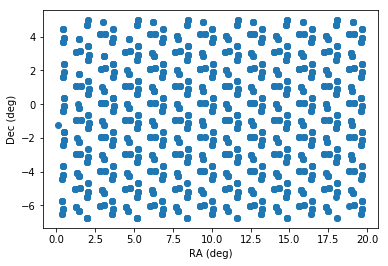

In [11]:
plt.scatter(df['RADEG'], df['DECDEG'])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

In [17]:
# Add the JD and equatorial barycentric vectors to the observatory to the exposure data frame
df['JD_OBS'] = df['MJD_OBS'] + 2400000.5
jd_utc = df['JD_OBS']
foo = np.array([Observatories.getObservatoryPosition('W84', jd) for jd in jd_utc])
df['xe'] = foo[:,0]
df['ye'] = foo[:,1]
df['ze'] = foo[:,2]

In [15]:
def raDec_to_xyz(raDec):
    raDeg  = raDec[:,0]
    decDeg = raDec[:,1]

    x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
    y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
    z = np.sin(decDeg*np.pi/180.)
    
    return np.stack((x, y, z), axis=1)

In [16]:
# Get the equatorial unit vectors to the exposure centers
raDec = df[['RADEG', 'DECDEG']].as_matrix()

xyz = raDec_to_xyz(raDec)
df['xc'] = xyz[:,0]
df['yc'] = xyz[:,1]
df['zc'] = xyz[:,2]


In [18]:
df

,EXPNUM,RADEG,DECDEG,DATE_OBS,BAND,EXPTIME,MJD_OBS,JD_OBS,xe,ye,ze,xc,yc,zc
0,229683,0.468621,0.377768,2013-09-02T06:10:47.837043,g,90.0,56537.257498,2.456538e+06,0.946924,-0.322540,-0.139930,0.999945,0.008179,0.006593
1,229684,2.065533,1.392268,2013-09-02T06:12:46.472481,g,90.0,56537.258871,2.456538e+06,0.946931,-0.322519,-0.139921,0.999055,0.036032,0.024297
2,229685,3.659758,2.406768,2013-09-02T06:15:01.886059,g,90.0,56537.260439,2.456538e+06,0.946940,-0.322496,-0.139911,0.997080,0.063775,0.041994
3,229688,3.663221,0.377768,2013-09-02T06:21:30.678404,g,90.0,56537.264938,2.456538e+06,0.946966,-0.322428,-0.139882,0.997935,0.063890,0.006593
4,229691,0.457838,-1.651232,2013-09-02T06:27:54.655251,g,90.0,56537.269383,2.456538e+06,0.946991,-0.322362,-0.139854,0.999553,0.007987,-0.028815
5,229692,3.655137,-1.651232,2013-09-02T06:30:06.609589,g,90.0,56537.270910,2.456538e+06,0.946999,-0.322339,-0.139844,0.997551,0.063724,-0.028815
6,229693,5.258321,-0.636732,2013-09-02T06:32:06.124497,g,90.0,56537.272293,2.456538e+06,0.947007,-0.322318,-0.139835,0.995730,0.091641,-0.011113
7,229694,6.857721,0.377768,2013-09-02T06:34:05.969268,g,90.0,56537.273680,2.456538e+06,0.947015,-0.322297,-0.139826,0.992824,0.119402,0.006593
8,229695,8.454933,1.392268,2013-09-02T06:36:08.302435,g,90.0,56537.275096,2.456538e+06,0.947023,-0.322276,-0.139817,0.988840,0.146988,0.024297
9,229696,10.051358,2.406768,2013-09-02T06:38:20.162801,g,90.0,56537.276622,2.456538e+06,0.947032,-0.322253,-0.139807,0.983783,0.174377,0.041994


In [19]:
# This rotation is taking things from equatorial to ecliptic
rot_mat = MPC_library.rotate_matrix(-MPC_library.Constants.ecl)
def equatorial_to_ecliptic(v, rot_mat=MPC_library.rotate_matrix(-MPC_library.Constants.ecl)):
    return np.dot(rot_mat, v.reshape(-1, 1)).flatten()

def equatorial_to_ecliptic_v2(v, rot_mat=MPC_library.rotate_matrix(-MPC_library.Constants.ecl)):
    return np.matmul(v, rot_mat.T)

In [20]:
# Convert the vector to the observatory and unit vector to the exposure center to ecliptic coordinates

ree = equatorial_to_ecliptic_v2(df[['xe', 'ye', 'ze']].as_matrix())
df['xe_ec'] = ree[:,0]
df['ye_ec'] = ree[:,1]
df['ze_ec'] = ree[:,2]

rce = equatorial_to_ecliptic_v2(df[['xc', 'yc', 'zc']].as_matrix())
df['xc_ec'] = rce[:,0]
df['yc_ec'] = rce[:,1]
df['zc_ec'] = rce[:,2]



In [21]:
# This returns the topocentric distances and new heliocentric
# position vectors to the target, given the assumed distance
# r and the position vector of the observatory re.
def adjust_position(r, rho_target, re):
    rho_x, rho_y, rho_z = rho_target
    xe, ye, ze = re
    Robs = np.sqrt(xe * xe + ye * ye + ze * ze)
    cos_phi = -(rho_x * xe + rho_y * ye + rho_z * ze) / Robs
    phi = np.arccos(cos_phi)
    sin_phi = np.sin(phi)

    xx2 = r*r - Robs*sin_phi * Robs*sin_phi
    
    if xx2 < 0:
        None, None

    xx = np.sqrt(xx2)
    yy = Robs * cos_phi
    
    rho_p = yy + xx

    # This could be done with numpy arrays
    x_p = xe + rho_p*rho_x
    y_p = ye + rho_p*rho_y
    z_p = ze + rho_p*rho_z
    
    rho_m = yy - xx
    
    # This could be done with numpy arrays    
    x_m = xe + rho_m*rho_x
    y_m = ye + rho_m*rho_y
    z_m = ze + rho_m*rho_z
        
    return (rho_p, (x_p, y_p, z_p)), (rho_m, (x_m, y_m, z_m))

Now let's compute the reference vector, which will be the average of the vectors from the barycenter to the exposure centers, assuming a distance of 40 AU.

In [22]:
re = df[['xe_ec', 'ye_ec', 'ze_ec']].as_matrix()
rc = df[['xc_ec', 'yc_ec', 'zc_ec']].as_matrix()

# Doing this as a loop, but it's not compute-intensive
rp = np.zeros((rc.shape))
for i, (rcp, rep) in enumerate(zip(rc, re)):
     ((_, tmp), (_, _)) = adjust_position(40.0, rcp, rep)
     rp[i] = np.array(tmp)


In [23]:
ref_vec = np.mean(rp, axis=0)
ref_vec /= np.linalg.norm(ref_vec)
ref_vec

array([ 0.98323679,  0.16221222, -0.08326226])

In [25]:
# Check again
# This routine returns the 3-D rotation matrix for the 
# given reference vector.
def xyz_to_proj_matrix(r_ref):
    x_ref, y_ref, z_ref = r_ref
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    mat = np.array([[-slon0, clon0, 0], 
                    [-clon0*slat0, -slon0*slat0, clat0], 
                    [clon0*clat0, slon0*clat0, slat0 ]])
    
    return mat



Now that the reference direction has been established, the next step is to transform the xe, ye, ze observatory postions to tangent plane coordinates and RA/Dec positions in each exposure to ecliptic coordinates and then to tangent plane coordinates.  This will result in theta_x, theta_y values for each position, which will be the primary input to the later steps of the algorithm.

We also establish the reference time as the mean of the exposure times.

In [26]:
mat = xyz_to_proj_matrix(ref_vec)

re_proj = np.matmul(re, mat.T)

df['xe_p'] = re_proj[:,0]
df['ye_p'] = re_proj[:,1]
df['ze_p'] = re_proj[:,2]


In [27]:
c = MPC_library.Constants.speed_of_light
GM = MPC_library.Constants.GMsun

In [28]:
# First, do this for just a single object to test the results.

raDecDict = defaultdict(list)
magIDDict = defaultdict(list)
for filename in filelist:
    with open(filename, newline='') as csvfile:
        spamreader = csv.DictReader(csvfile)
        for i, row in enumerate(spamreader):
            if i==0:
                print(row)
            key = int(row['expnum'])
#            if int(row['fakeid'])==180109419:
#            if int(row['fakeid'])==180159275:
            if int(row['fakeid'])==180147080:
                magIDDict[key].append((float(row['mag']), int(row['objid']), int(row['fakeid'])))
                raDecDict[key].append((float(row['ra']), float(row['dec'])))

justThese=magIDDict.keys()

xyz_proj = defaultdict(np.array)
#for expnum in df['EXPNUM']:
for expnum in justThese:
    raDec = np.array(raDecDict[expnum])
    if raDec.shape[0]>0:
        xyz = raDec_to_xyz(raDec)
        xyz_ec = equatorial_to_ecliptic_v2(xyz)
        xyz_proj[expnum] = np.matmul(xyz_ec, mat.T)

{'mjd': '56544.189986000005', 'mag': '21.226', 'objid': '227594796', 'HPIX_1024': '4456041', 'exptime': '90.0', 'HPIX_16': '1087', 'HPIX_32': '4351', 'fakeid': '180061594', 'ccd': '26', 'expnum': '231922', 'HPIX_512': '1114010', 'HPIX_256': '278502', 'mag_from_limit': '3.372', 'band': 'g', 'dec': '-1.1987762826140012', 'HPIX_128': '69625', 'nite': '20130908', 'date': '2013/9/9 04:33:35', 'HPIX_64': '17406', 'ml_score': '0.9670000000000001', 'ra': '359.4563006020627', 'snr': '36.685'}
{'mjd': '56958.183438199994', 'mag': '22.813000000000002', 'objid': '231859269', 'HPIX_1024': '4805892', 'exptime': '90.0', 'HPIX_16': '1173', 'HPIX_32': '4693', 'fakeid': '180156619', 'ccd': '32', 'expnum': '372120', 'HPIX_512': '1201473', 'HPIX_256': '300368', 'mag_from_limit': '2.1069999999999998', 'band': 'r', 'dec': '-0.4781901968101665', 'HPIX_128': '75092', 'nite': '20141027', 'date': '2014/10/28 04:24:09', 'HPIX_64': '18773', 'ml_score': '0.93', 'ra': '359.36581553365045', 'snr': '8.792'}
{'mjd': '

In [29]:
%%time

thresh = 5
rad = (np.pi/180.)*(0.01/3600.)

# With reference direction from first observation
# 0.00165551  0.00073627 -0.00010067 -0.00024954  0.00313782  0.00071216

#alpha_dot = 0.00073627/365.25
#beta_dot = -0.00024954/365.25

#gamma = 0.00313782  
#gamma_dot = 0.00071216/365.25

# After adjusting reference direction
# 0.05283919  0.00077423  0.06707400 -0.00020518  0.00314923  0.00069145

# After sorting the times
# 0.05283919  0.00077411  0.06707400 -0.00020534  0.00314923  0.00068910

alpha_dot = 0.00077411/365.25
beta_dot = -0.00020534/365.25

gamma = 0.00314923 
gamma_dot = 0.00068910/365.25

alpha = 1.26587450e-01     
alpha_dot = 2.41858516e-07 
beta = -7.61819057e-02    
beta_dot = -2.15609750e-07
gamma = 8.48034701e-04
gamma_dot = 2.74588074e-07   


per = 365.25*np.power(gamma, -1.5)
n = 2.0*np.pi/per

print(n)

print(n, gamma, alpha_dot, beta_dot, gamma_dot)


alpha_p = []
beta_p = []
fakeIDs = []
tps = []
xs = []
ys = []
xes = []
yes = []
zes = []

# choose the range of alpha_dot and beta_dot based on gamma

# choose gamma
# compute tp

t0 = df['JD_OBS'].mean()

tp = df['JD_OBS'] - t0 - 1.0/(gamma*c)

df['tp'] = tp
df['tp2'] = tp*tp

# choose gamma_dot
# compute f

f = 1.0 - 0.5*GM * gamma**3 * df['tp2'] - gamma * df['ze_p'] + gamma_dot * df['tp']

h  = 1.0 - 0.5*GM * gamma**3 * df['tp2']

df['f'] = f
df['h'] = h

# compute the theta_x*f + gamma*xe and theta_y*f + gamma*ye parts
# those are the basic exposure arrays
for expnum, tp, f, xe, ye, ze, h in zip(df['EXPNUM'], df['tp'], df['f'], df['xe_p'], df['ye_p'], df['ze_p'], df['h']):
    if expnum in justThese:
        for row, row2 in zip(xyz_proj[expnum], magIDDict[expnum]):
            xp, yp, zp = row
            theta_x = xp/zp
            theta_y = yp/zp
            _, _, fakeID = row2
            alpha_p.append((theta_x*f + gamma*xe - alpha_dot*tp)/h)
            beta_p.append((theta_y*f + gamma*ye - beta_dot*tp)/h)
            fakeIDs.append(fakeID)
            tps.append(tp)
            xs.append(theta_x)
            ys.append(theta_y)
            xes.append(xe)
            yes.append(ye)
            zes.append(ze)

# Keep the unshifted arrays.  Then carry out a series of alpha_dot, beta_dot shifts,
# building a KD-tree and searching for clusters after each shift.


alpha_p = np.array(alpha_p)
beta_p = np.array(beta_p)
times = np.array(tps)
xs = np.array(xs)
ys = np.array(ys)

xes = np.array(xes)
yes = np.array(yes)
zes = np.array(zes)

points = np.vstack((alpha_p, beta_p)).T

cluster_set = set()


tree = scipy.spatial.cKDTree(points)
matches = tree.query_ball_tree(tree, rad)
for j, match in enumerate(matches):
    if len(match)>=thresh:
        cluster_set.update({tuple(match)})

cluster_set


4.24825012862e-07
4.24825012862e-07 0.000848034701 2.41858516e-07 -2.1560975e-07 2.74588074e-07
CPU times: user 5.1 ms, sys: 272 µs, total: 5.37 ms
Wall time: 5.27 ms


In [31]:
for cluster in cluster_set:
    for i, elt in enumerate(cluster):
        print(i, elt, fakeIDs[elt], tps[elt], points[elt])
    print()


0 0 180147080 -245.752079984 [ 0.12658523 -0.07618398]
1 1 180147080 -220.820426084 [ 0.12658528 -0.07618398]
2 2 180147080 446.345941716 [ 0.12658526 -0.07618398]
3 3 180147080 505.111249916 [ 0.12658525 -0.07618398]
4 4 180147080 511.163879216 [ 0.12658525 -0.07618398]



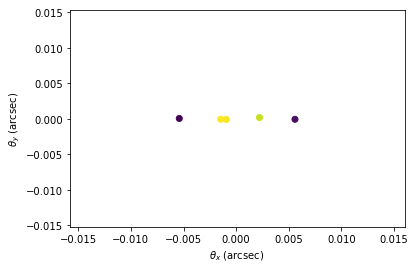

In [39]:
plt.scatter((alpha_p-alpha_p.mean())*206265, (beta_p-beta_p.mean())*206265, c=times)
plt.xlabel(r'$\theta_x$ (arcsec)')
plt.ylabel(r'$\theta_y$ (arcsec)')
#plt.xlim(-0.005, 0.005)
#plt.ylim(-0.005, 0.005)


In [40]:
points[:, 0].min(), points[:, 0].max(), points[:, 1].min(), points[:, 1].max()

(0.12658522702903707,
 0.12658528031658856,
 -0.076183979618748385,
 -0.076183978338626057)

I am going to output the detections for processing with the modified Berstein code, to be able to see the fitted orbital parameters.

In [ ]:
# compute the theta_x*f + gamma*xe and theta_y*f + gamma*ye parts
# those are the basic exposure arrays
with open('DES_detections.txt', 'w') as file:
    for expnum, t in zip(df['EXPNUM'], df['JD_OBS']):
        for row, row2 in zip(raDecDict[expnum], magIDDict[expnum]):
            ra, dec = row
            _, _, fakeID = row2
            outstring = "%d %.16lf %.16lf %.16lf 0.2 807\n" % (fakeID, t, ra, dec)
            file.write(outstring)


In [ ]:
# Output the observations for all the synthetic objects to calculate their fitted orbital parameters.

mpc_output_dict = defaultdict(list)
for filename in filelist:
    with open(filename, newline='') as csvfile:
        spamreader = csv.DictReader(csvfile)
        for i, row in enumerate(spamreader):
            fakeid = int(row['fakeid'])
            outstring = "%d %.16lf %.16lf %.16lf %.1lf %d" % (int(row['fakeid']), float(row['mjd']) + 2400000.5, float(row['ra']), float(row['dec']), 0.2, 807)
            mpc_output_dict[fakeid].append(outstring)


outfile = open('DES_parameters.out', 'w')
outfile.close()
for key in sorted(mpc_output_dict.keys()):
    val = mpc_output_dict[key]
    if len(val)>=5:
        sorted_string = sorted(val, key=lambda x: x[10:34])
        instring = '\n'.join(sorted_string)
        infile = open('DES_'+str(key), 'w')
        infile.write(instring)
        infile.close()
        command='/Users/mholman/Dropbox/planet_x/orbfit.v2/fit_radec_des 2457172.751213126 0.98323697 0.16221004 -0.08326437 <' + 'DES_' + str(key) + ' >> DES_parameters.out'
        print(command)
        os.system(command)
    else:
        outfile = open('DES_parameters.out', 'a')
        outfile.write(str(key)+'\n')
        outfile.close()

In [ ]:
parameters_dict = {}
for line in open('DES_parameters.out', 'r'):
    vals = line.strip().split()
    key = int(vals[0])
    if len(vals) > 1:
        nobs = int(vals[1])
        alpha = float(vals[2])
        alpha_dot = float(vals[3])        
        beta = float(vals[4])        
        beta_dot = float(vals[5])
        gamma = float(vals[6])
        gamma_dot = float(vals[7])
        a = float(vals[8])
        e = float(vals[9])
        incl = float(vals[10])
        dur = float(vals[11])
        parameters_dict[key] = {'nobs': nobs, 
                                'alpha': alpha, 'alpha_dot': alpha_dot, 
                                'beta': beta, 'beta_dot': beta_dot,
                                'gamma': gamma, 'gamma_dot': gamma_dot,
                                'a': a, 'e': e, 'incl': incl, 'dur': dur}
    else:
        parameters_dict[key] = None

    

In [ ]:
parameters_dict

In [ ]:
# Now I am going to collect the data for all the objects, to do search runs.

raDecDict = defaultdict(list)
magIDDict = defaultdict(list)
#for filename in filelist:
for filename in scrambledlist:
    with open(filename, newline='') as csvfile:
        spamreader = csv.DictReader(csvfile)
        for i, row in enumerate(spamreader):
            if i==0:
                print(row)
            key = int(row['expnum'])
            #if int(row['fakeid'])==180109419:
            magIDDict[key].append((float(row['mag']), int(row['objid']), int(row['fakeid'])))
            raDecDict[key].append((float(row['ra']), float(row['dec'])))

justThese=magIDDict.keys()

xyz_proj = defaultdict(np.array)
#for expnum in df['EXPNUM']:
for expnum in justThese:
    raDec = np.array(raDecDict[expnum])
    if raDec.shape[0]>0:
        xyz = raDec_to_xyz(raDec)
        xyz_ec = equatorial_to_ecliptic_v2(xyz)
        xyz_proj[expnum] = np.matmul(xyz_ec, mat.T)

In [ ]:
%%time

thresh = 5
rad = (np.pi/180.)*(0.01/3600.)

# With reference direction from first observation
# 0.00165551  0.00073627 -0.00010067 -0.00024954  0.00313782  0.00071216

#alpha_dot = 0.00073627/365.25
#beta_dot = -0.00024954/365.25

#gamma = 0.00313782  
#gamma_dot = 0.00071216/365.25

# After adjusting reference direction
# 0.05283919  0.00077423  0.06707400 -0.00020518  0.00314923  0.00069145

# After sorting the times
# 0.05283919  0.00077411  0.06707400 -0.00020534  0.00314923  0.00068910

alpha_dot = 0.00077411/365.25
beta_dot = -0.00020534/365.25

gamma = 0.00314923 
gamma_dot = 0.00068910/365.25

alpha = 1.26587450e-01     
alpha_dot = 2.41858516e-07 
beta = -7.61819057e-02    
beta_dot = -2.15609750e-07
gamma = 8.48034701e-04
gamma_dot = 2.74588074e-07   


per = 365.25*np.power(gamma, -1.5)
n = 2.0*np.pi/per

print(n)

print(n, gamma, alpha_dot, beta_dot, gamma_dot)


alpha_p = []
beta_p = []
fakeIDs = []
tps = []
xs = []
ys = []
xes = []
yes = []
zes = []

# choose the range of alpha_dot and beta_dot based on gamma

# choose gamma
# compute tp

t0 = df['JD_OBS'].mean()

tp = df['JD_OBS'] - t0 - 1.0/(gamma*c)

df['tp'] = tp
df['tp2'] = tp*tp

# choose gamma_dot
# compute f

f = 1.0 - 0.5*GM * gamma**3 * df['tp2'] - gamma * df['ze_p'] + gamma_dot * df['tp']

h  = 1.0 - 0.5*GM * gamma**3 * df['tp2']

df['f'] = f
df['h'] = h

# compute the theta_x*f + gamma*xe and theta_y*f + gamma*ye parts
# those are the basic exposure arrays
for expnum, tp, f, xe, ye, ze, h in zip(df['EXPNUM'], df['tp'], df['f'], df['xe_p'], df['ye_p'], df['ze_p'], df['h']):
    if expnum in justThese:
        for row, row2 in zip(xyz_proj[expnum], magIDDict[expnum]):
            xp, yp, zp = row
            theta_x = xp/zp
            theta_y = yp/zp
            _, _, fakeID = row2
            alpha_p.append((theta_x*f + gamma*xe - alpha_dot*tp)/h)
            beta_p.append((theta_y*f + gamma*ye - beta_dot*tp)/h)
            fakeIDs.append(fakeID)
            tps.append(tp)
            xs.append(theta_x)
            ys.append(theta_y)
            xes.append(xe)
            yes.append(ye)
            zes.append(ze)

# Keep the unshifted arrays.  Then carry out a series of alpha_dot, beta_dot shifts,
# building a KD-tree and searching for clusters after each shift.


alpha_p = np.array(alpha_p)
beta_p = np.array(beta_p)
times = np.array(tps)
xs = np.array(xs)
ys = np.array(ys)

xes = np.array(xes)
yes = np.array(yes)
zes = np.array(zes)

points = np.vstack((alpha_p, beta_p)).T

cluster_set = set()


tree = scipy.spatial.cKDTree(points)
matches = tree.query_ball_tree(tree, rad)
for j, match in enumerate(matches):
    if len(match)>=thresh:
        cluster_set.update({tuple(match)})

cluster_set



In [ ]:
points.shape

In [ ]:
%%time
points_s = points[points[:,0].argsort()]

In [ ]:
points_s

In [ ]:
points[:,0].argsort()

In [ ]:
%%time
dy = 0.0001
args = np.floor(points[:,1]//dy).astype(int)
idx = np.lexsort((points[:,0], args))
points_s=points[idx]

trans=np.argwhere((points_s[1:,0]-points_s[:-1, 0])<0)+1

In [ ]:
trans

In [ ]:
for i in range(10000, 20000):
    print(points_s[i])

In [ ]:
trans[1000:1010]

In [ ]:
points_s[995032:995035]

In [ ]:
for i, t in enumerate(trans):
    print(i, points_s[t-1:t+2])

I need to write a c routine with a python wrapper that will do the strip-based neighbor calculation.  It needs to accept a sorted points array, with a dy value, an r value, a cluster membership threshold, and an array of start indices.

The routine then marches down each strip, keeping track of the last near index, looking for values in that strip and the neighboring strips that are closer than r.  The returned values are the clusters.


In [ ]:
points_s

In [ ]:
plt.scatter(points[:,0], points[:,1], c=args)
plt.xlim(-0.3,0.3)
plt.ylim(-0.3,0.3)

In [ ]:
plt.scatter(points_s[:,0], points_s[:,1])
plt.xlim(-0.3,0.3)
plt.ylim(-0.3,0.3)
plt.savefig('shifted.png')

In [ ]:
plt.scatter(xs, ys)
plt.xlim(-0.3,0.3)
plt.ylim(-0.3,0.3)
plt.savefig('unshifted.png')

In [ ]:
points_s[:, 1].min(), points_s[:, 1].max()

In [ ]:
xs.shape

In [ ]:
points

In [ ]:
# I want to alter this so that it does the full range of alpha_dot and beta_dot for a given value or values of gamma
# and a given step size in alpha_dot and beta_dot.

thresh = 6
rad = (np.pi/180.)*(20./3600.)


gamma = 0.02
gamma_dot = 0.0

per = 365.25*np.power(gamma, -1.5)
n = 2.0*np.pi/per

alpha_dot = n
beta_dot = 0.2*n

fakeIDs = []

def single_detection_clusters(df, xyz_proj, magIDDict, 
                              gamma, gamma_dot, alpha_dot_beta_dot_pairs,
                              thresh, rad, GM):
    
    ntotal = np.sum([v.shape[0] for key, v in xyz_proj.items()])
        
    theta  = np.zeros((ntotal, 2))
    re     = np.zeros((ntotal, 3))
    points = np.zeros((ntotal, 2))
    points0 = np.zeros((ntotal, 2))    
    fs     = np.zeros(ntotal)
    
    #fakeIDs = []
    #tps = []

    # choose the range of alpha_dot and beta_dot based on gamma
    
    # choose gamma
    # compute tp

    # This can be done up front.
    t0 = df['JD_OBS'].mean()

    #tp_arr = df['JD_OBS'] - t0 - 1.0/(gamma*c)
    #tp2_arr = tp_arr*tp_arr
    
    ts = np.zeros(ntotal)

    # choose gamma_dot
    # compute f

    # Iterate over the exposures to set up the data
    i=0
    for expnum, t, xe, ye, ze in zip(df['EXPNUM'], df['JD_OBS'], df['xe_p'], df['ye_p'], df['ze_p']):
        
        # Iterate over the detections in each exposure, filling in some arrays
        for row, row2 in zip(xyz_proj[expnum], magIDDict[expnum]):
            xp, yp, zp = row
            theta_x = xp/zp
            theta_y = yp/zp
            _, _, fakeID = row2
            
            ts[i] = t-t0

            theta[i][0] = theta_x
            theta[i][1] = theta_y
            
            re[i][0] = xe
            re[i][1] = ye
            re[i][2] = ze
            
            fakeIDs.append(fakeID)
            
            i += 1

    # Now we have arrays of theta, re, and ts, but those could actually be the input 
    # to the routine.
    
    # The rest of this is very simple.
    
    # The gamma loop starts here:
    
    tp = ts-1.0/(gamma*c)
    

    # The gamma_dot loop starts here.
    # The range of gamma_dot depends upon the value of gamma
    
    f_arr = 1.0 - 0.5*GM * gamma**3 * tp*tp - gamma * re[:, 2] + gamma_dot * tp
    h_arr = 1.0 - 0.5*GM * gamma**3 * tp*tp
    
    points0 = theta*f_arr[:, np.newaxis] + gamma*re[:, 0:2]
    
    # The unshifted array points0 is now established for the given gamma, gamma_dot.  
    
    # Now carry out a series of alpha_dot, beta_dot shifts,
    # building a KD-tree and searching for clusters after each shift.
    # The range of alpha_dot and beta_dot depends upon the value of gamma.

    cluster_set_dict=defaultdict(set)
    
    for alpha_dot, beta_dot in alpha_dot_beta_dot_pairs:
        points[:, 0] = (points0[:, 0] - alpha_dot*tp)/h_arr
        points[:, 1] = (points0[:, 1] -  beta_dot*tp)/h_arr
    
        #cluster_set = set()

        tree = scipy.spatial.cKDTree(points)
        matches = tree.query_ball_tree(tree, rad)
        for j, match in enumerate(matches):
            if len(match)>=thresh:
                cluster_set_dict[tuple(match)].update({(alpha_dot, beta_dot)})

        #cluster_set_dict[(alpha_dot, beta_dot)] = cluster_set

    return cluster_set_dict, tp



In [ ]:
%%time 

thresh = 12
rad = (np.pi/180.)*(20./3600.)

alpha_dot = 0.00077411/365.25
beta_dot = -0.00020534/365.25

gamma = 0.00314923 
gamma_dot = 0.00068910/365.25

#gamma = 0.011
#gamma_dot = 0.0

per = 365.25*np.power(gamma, -1.5)
print(per/365.25)
n = 1.5*np.pi/per

#alpha_dot = n
#beta_dot = 0.0*n

apts, bpts = np.meshgrid(np.linspace(0.9, 1.1, 5)*alpha_dot, np.linspace(0.9, 1.1, 5)*beta_dot)
alpha_dot_beta_dot_pairs = list(zip(apts.flatten(), bpts.flatten()))

#alpha_dot_beta_dot_pairs = zip(np.linspace(-1, 1, 101)*alpha_dot, np.linspace(1, 1, 101)*beta_dot)

cluster_set_dict, tps = single_detection_clusters(df, xyz_proj, magIDDict, 
                              gamma, gamma_dot, alpha_dot_beta_dot_pairs,
                              thresh, rad, GM)

In [ ]:
# I want to alter this so that it does the full range of alpha_dot and beta_dot for a given value or values of gamma
# and a given step size in alpha_dot and beta_dot.

def single_detection_clusters(df, xyz_proj, magIDDict, 
                              gamma, gamma_dot, delta_alpha_dot, delta_beta_dot,
                              thresh, rad, GM):
    
    # Given gamma, figure out the maximum values of alpha_dot and beta_dot
    
    ntotal = np.sum([v.shape[0] for key, v in xyz_proj.items()])
        
    theta  = np.zeros((ntotal, 2))
    re     = np.zeros((ntotal, 3))
    points = np.zeros((ntotal, 2))
    points0 = np.zeros((ntotal, 2))    
    fs     = np.zeros(ntotal)
    
    fakeIDs = []

    # choose the range of alpha_dot and beta_dot based on gamma
    
    # choose gamma
    # compute tp

    # This can be done up front.
    t0 = df['JD_OBS'].mean()

    ts = np.zeros(ntotal)

    # Iterate over the exposures to set up the data
    i=0
    for expnum, t, xe, ye, ze in zip(df['EXPNUM'], df['JD_OBS'], df['xe_p'], df['ye_p'], df['ze_p']):
        
        # Iterate over the detections in each exposure, filling in some arrays
        for row, row2 in zip(xyz_proj[expnum], magIDDict[expnum]):
            xp, yp, zp = row
            theta_x = xp/zp
            theta_y = yp/zp
            _, _, fakeID = row2
            
            ts[i] = t-t0

            theta[i][0] = theta_x
            theta[i][1] = theta_y
            
            re[i][0] = xe
            re[i][1] = ye
            re[i][2] = ze
            
            fakeIDs.append(fakeID)
            
            i += 1

    # Now we have arrays of theta, re, and ts, but those could actually be the input 
    # to the routine.
    
    # The gamma loop starts here:
    
    angular_rate_max = np.sqrt(2.0 * GM * gamma**3)
    
    na = ((angular_rate_max // delta_alpha_dot) + 1)
    alpha_dot_max = na * delta_alpha_dot
    
    nb = ((angular_rate_max // delta_beta_dot) + 1)
    beta_dot_max = nb * delta_beta_dot
    
    alpha_dots = np.linspace(-alpha_dot_max, alpha_dot_max, 2*na - 1)
    beta_dots  = np.linspace(-beta_dot_max, beta_dot_max, 2*nb - 1)
    
    apts, bpts = np.meshgrid(alpha_dots, beta_dots)
    alpha_dot_beta_dot_pairs = list(zip(apts.flatten(), bpts.flatten()))
    
    print(len(alpha_dots), len(beta_dots), len(alpha_dot_beta_dot_pairs))
    
    tp = ts-1.0/(gamma*c)
    

    # The gamma_dot loop starts here.
    # The range of gamma_dot depends upon the value of gamma
    
    f_arr = 1.0 - 0.5*GM * gamma**3 * tp*tp - gamma * re[:, 2] + gamma_dot * tp
    h_arr = 1.0 - 0.5*GM * gamma**3 * tp*tp
    
    points0 = theta*f_arr[:, np.newaxis] + gamma*re[:, 0:2]
    
    # The unshifted array points0 is now established for the given gamma, gamma_dot.  
    
    # Now carry out a series of alpha_dot, beta_dot shifts,
    # building a KD-tree and searching for clusters after each shift.
    # The range of alpha_dot and beta_dot depends upon the value of gamma.

    cluster_set_dict=defaultdict(set)
    
    for alpha_dot, beta_dot in alpha_dot_beta_dot_pairs:
        points[:, 0] = (points0[:, 0] - alpha_dot*tp)/h_arr
        points[:, 1] = (points0[:, 1] -  beta_dot*tp)/h_arr
    
        #cluster_set = set()

        tree = scipy.spatial.cKDTree(points)
        matches = tree.query_ball_tree(tree, rad)
        for j, match in enumerate(matches):
            if len(match)>=thresh:
                cluster_set_dict[tuple(match)].update({(alpha_dot, beta_dot)})

        #cluster_set_dict[(alpha_dot, beta_dot)] = cluster_set

    return cluster_set_dict, tp, fakeIDs




In [ ]:
%%time 

thresh = 6
rad = (np.pi/180.)*(20./3600.)

gamma = 0.00314923 
gamma_dot = 0.00068910/365.25

gamma = 0.001
gamma_dot = 0.0

delta_alpha_dot = 1.2e-7
delta_beta_dot  = 1.2e-7

cluster_set_dict, tps, fakeIDs = single_detection_clusters(df, xyz_proj, magIDDict, 
                              gamma, gamma_dot, delta_alpha_dot, delta_beta_dot,
                              thresh, rad, GM)

In [ ]:
# Now alter this to do a set of gamma and gamma_dot pairs. 

def single_detection_clusters(df, xyz_proj, magIDDict, 
                              gamma_gamma_dot_pairs, delta_alpha_dot, delta_beta_dot,
                              thresh, rad, GM):
    
    # Given gamma, figure out the maximum values of alpha_dot and beta_dot
    
    ntotal = np.sum([v.shape[0] for key, v in xyz_proj.items()])
        
    theta  = np.zeros((ntotal, 2))
    re     = np.zeros((ntotal, 3))
    points = np.zeros((ntotal, 2))
    points0 = np.zeros((ntotal, 2))    
    fs     = np.zeros(ntotal)
    
    fakeIDs = []

    # choose the range of alpha_dot and beta_dot based on gamma
    
    # choose gamma
    # compute tp

    # This can be done up front.
    t0 = df['JD_OBS'].mean()
    #t0 = df['JD_OBS'].mean() - 100.0

    ts = np.zeros(ntotal)

    # Iterate over the exposures to set up the data
    i=0
    for expnum, t, xe, ye, ze in zip(df['EXPNUM'], df['JD_OBS'], df['xe_p'], df['ye_p'], df['ze_p']):
        
        # Iterate over the detections in each exposure, filling in some arrays
        for row, row2 in zip(xyz_proj[expnum], magIDDict[expnum]):
            xp, yp, zp = row
            theta_x = xp/zp
            theta_y = yp/zp
            _, _, fakeID = row2
            
            ts[i] = t-t0

            theta[i][0] = theta_x
            theta[i][1] = theta_y
            
            re[i][0] = xe
            re[i][1] = ye
            re[i][2] = ze
            
            fakeIDs.append(fakeID)
            
            i += 1
    
    print(theta[:, 0].mean(), theta[:, 0].min(), theta[:, 0].max(), theta[:, 1].mean(), theta[:, 1].min(), theta[:, 1].max())

    # Now we have arrays of theta, re, and ts, but those could actually be the input 
    # to the routine.
    
    for gamma, gamma_dot in gamma_gamma_dot_pairs:
        
        tp = ts-1.0/(gamma*c)

        # I don't think the signs in front of the GM terms are correct as minus.  Trying plus.
        f_arr = 1.0 - 0.5*GM * gamma**3 * tp*tp - gamma * re[:, 2] + gamma_dot * tp
        h_arr = 1.0 - 0.5*GM * gamma**3 * tp*tp
    
        points0 = theta*f_arr[:, np.newaxis] + gamma*re[:, 0:2]
        
        # The unshifted array points0 is now established for the given gamma, gamma_dot.  
    
        # Now carry out a series of alpha_dot, beta_dot shifts,
        # building a KD-tree and searching for clusters after each shift.
        # The range of alpha_dot and beta_dot depends upon the value of gamma.
    
        angular_rate_max = np.sqrt(2.0 * GM * gamma**3)
    
        na = ((angular_rate_max // delta_alpha_dot) + 1)
        alpha_dot_max = na * delta_alpha_dot
    
        nb = ((angular_rate_max // delta_beta_dot) + 1)
        beta_dot_max = nb * delta_beta_dot
    
        alpha_dots = np.linspace(-alpha_dot_max, alpha_dot_max, 2*na - 1)
        beta_dots  = np.linspace(-beta_dot_max, beta_dot_max, 2*nb - 1)
    
        apts, bpts = np.meshgrid(alpha_dots, beta_dots)
        alpha_dot_beta_dot_pairs = list(zip(apts.flatten(), bpts.flatten()))
        
        print(gamma, na, nb, len(alpha_dot_beta_dot_pairs))
    
        #cluster_set_dict=defaultdict(set)
        cluster_set_dict=defaultdict(int)
    
        for alpha_dot, beta_dot in alpha_dot_beta_dot_pairs:
            points[:, 0] = (points0[:, 0] - alpha_dot*tp)/h_arr
            points[:, 1] = (points0[:, 1] -  beta_dot*tp)/h_arr

            #print(points[:, 0].min(), points[:, 0].max(), points[:, 1].min(), points[:, 1].max())
            
            tree = scipy.spatial.cKDTree(points)
            
            matches = tree.query_ball_tree(tree, rad)
            for j, match in enumerate(matches):
                if len(match)>=thresh:
                    #cluster_set_dict[tuple(match)].update({(gamma, gamma_dot, alpha_dot, beta_dot)})
                    cluster_set_dict[tuple(match)] += 1

    return cluster_set_dict, tp, fakeIDs




In [ ]:
%%time 

thresh = 5
rad = (np.pi/180.)*(50./3600.)

#gamma = 0.00314923 
#gamma_dot = 0.00068910/365.25

#gamma_dot = 0.0

#gamma_dot = 2.74588074e-07 

#alpha = 1.26587450e-01     
#alpha_dot = 2.41858516e-07 
#beta = -7.61819057e-02    
#beta_dot = -2.15609750e-07
#gamma = 8.48034701e-04
#gamma_dot = 2.74588074e-07   

gamma = 0.0
gamma_dot = 0.0 

gamma_gamma_dot_pairs = list(map(lambda x: (x + gamma, gamma_dot), np.arange(0e-4, 21e-4, 2.0e-4)))

#gamma_gamma_dot_pairs = [(gamma, gamma_dot)]

delta_alpha_dot = 2.0e-7
delta_beta_dot  = 2.0e-7

cluster_set_dict, tps, fakeIDs = single_detection_clusters(df, xyz_proj, magIDDict, 
                              gamma_gamma_dot_pairs, delta_alpha_dot, delta_beta_dot,
                              thresh, rad, GM)

In [ ]:
xpts, ypts = np.meshgrid(np.linspace(-0.15, 0.15, 101), np.linspace(-0.12, 0.12, 101))
xpts_ypts_pairs = list(zip(xpts.flatten(), ypts.flatten()))
grid = np.array(xpts_ypts_pairs)
qtree = scipy.spatial.cKDTree(grid)

In [ ]:
points

In [ ]:
len(set(xpts_ypts_pairs))

In [ ]:
_, _, _ = plt.hist(list(cluster_set_dict.values()), bins=100, range=(0, 200))

Try using different t0 values to disentangle contaminated clusters.

Why might it be difficult to find particular objects:

1. Not very many detections

2. Detections spread out in time

3. Solution overlapping that of another object

4. Object far from the center of the tangent plane


In [ ]:
results = defaultdict(int)
for cluster, val in cluster_set_dict.items():
    if len(cluster) >= 5:
        '''
        for pair in sorted(val):
            print(pair)
        '''
        time_list = []
        for i, elt in enumerate(cluster):
            print(i, elt, fakeIDs[elt], tps[elt])
            time_list.append(tps[elt])
        id_set = set([fakeIDs[elt] for elt in cluster])
        if len(id_set) == 1:
            print('pure:', id_set, max(time_list)-min(time_list))
            id = list(id_set)[0]
            if len(cluster) > results[id]:
                results[id] = len(cluster)
        else:
            print('contaminated:', id_set)
        #print()

In [ ]:
total = 0
got = 0
for_plot = []
for key, params in parameters_dict.items():
    if params and params['gamma'] < 0.0022:
        total += 1
        v = 206265*np.sqrt(params['alpha_dot']*params['alpha_dot']+params['beta_dot']*params['beta_dot'])
        if not key in results:
            print(key, params['alpha'], params['alpha_dot'], params['beta'], params['beta_dot'], params['gamma'], params['gamma_dot'], params['nobs'], params['dur'])
            for_plot.append((params['alpha'], params['beta'], params['gamma_dot'], params['dur'], v, 0))
        else:
            got += 1
            print(key, params['alpha'], params['alpha_dot'], params['beta'], params['beta_dot'], params['gamma'], params['gamma_dot'], params['nobs'], params['dur'], 'got')
            #print(key, params['gamma'], params['gamma_dot'], params['alpha'], params['beta'], params['nobs'], params['dur'], 'got')
            for_plot.append((params['alpha'], params['beta'], params['gamma_dot'], params['dur'], v, 1))
            pass

for_plot = np.array(for_plot)
got, total, got/total

In [ ]:
plt.scatter(for_plot[:,0], for_plot[:,1], c=for_plot[:,5], s=10+30*(1-for_plot[:,5]))
#plt.xlim(-0.2, 0.2)
#plt.ylim(-0.2, 0.2)
#fig=plt.figure(figsize=(18, 18), dpi= 80, facecolor='w', edgecolor='k')

In [ ]:
for_plot

In [ ]:
plt.hist(for_plot[:,3], bins=20)

In [ ]:
plt.hist(for_plot[:,4], bins=20)

In [ ]:
plt.hist(206265*np.abs(for_plot[:,2]), bins=20)

In [ ]:
np.mean(for_plot[:,3])

Now we want to loop over a few adjacent reference vectors, repeating the search, to see if the results are more complete.

In [ ]:
%%time

thresh = 5
rad = (np.pi/180.)*(50./3600.)

#gamma = 0.00314923 
#gamma_dot = 0.00068910/365.25

#gamma_dot = 0.0

#gamma_dot = 2.74588074e-07 

#alpha = 1.26587450e-01     
#alpha_dot = 2.41858516e-07 
#beta = -7.61819057e-02    
#beta_dot = -2.15609750e-07
#gamma = 8.48034701e-04
#gamma_dot = 2.74588074e-07   

gamma = 0.0
gamma_dot = 0.0 

gamma_gamma_dot_pairs = list(map(lambda x: (x + gamma, gamma_dot), np.arange(0e-4, 21e-4, 2.0e-4)))

#gamma_gamma_dot_pairs = [(gamma, gamma_dot)]

delta_alpha_dot = 1.2e-7
delta_beta_dot  = 1.2e-7

nside=4
angDeg = 15
xp, yp, zp = ref_vec
pix = hp.vec2pix(nside, xp, yp, zp, nest=True)
vec = hp.pix2vec(nside, pix, nest=True)
neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)

cluster_results = {}

re = df[['xe_ec', 'ye_ec', 'ze_ec']].as_matrix()

for pix in neighbors:
    print(pix)
    vec = hp.pix2vec(nside, pix, nest=True)
    mat = xyz_to_proj_matrix(vec)

    re_proj = np.matmul(re, mat.T)

    df['xe_p'] = re_proj[:,0]
    df['ye_p'] = re_proj[:,1]
    df['ze_p'] = re_proj[:,2]

    xyz_proj = defaultdict(np.array)
    for expnum in justThese:
        raDec = np.array(raDecDict[expnum])
        if raDec.shape[0]>0:
            xyz = raDec_to_xyz(raDec)
            xyz_ec = equatorial_to_ecliptic_v2(xyz)
            xyz_proj[expnum] = np.matmul(xyz_ec, mat.T)
            
    cluster_results[pix], tps, fakeIDs = single_detection_clusters(df, xyz_proj, magIDDict, 
                                                                   gamma_gamma_dot_pairs, 
                                                                   delta_alpha_dot, delta_beta_dot, thresh, rad, GM)

In [ ]:
results = {}
for pix in neighbors:
    results[pix] = defaultdict(int)
    for cluster, val in cluster_results[pix].items():
        if len(cluster) >= 5:
            time_list = []
            for i, elt in enumerate(cluster):
                #print(i, elt, fakeIDs[elt], tps[elt])
                time_list.append(tps[elt])
            id_set = set([fakeIDs[elt] for elt in cluster])
            if len(id_set) == 1:
                print('pure:', id_set, max(time_list)-min(time_list))
                id = list(id_set)[0]
                if len(cluster) > results[pix][id]:
                    results[pix][id] = len(cluster)
            else:
                print('contaminated:', id_set)
        #print()

In [ ]:
for pix in neighbors:
    total = 0
    got = 0
    for_plot = []
    for key, params in parameters_dict.items():
        if params and params['gamma'] < 0.0022:
            total += 1
            v = 206265*np.sqrt(params['alpha_dot']*params['alpha_dot']+params['beta_dot']*params['beta_dot'])
            if not key in results[pix]:
                print(key, params['gamma'], 206265*params['gamma_dot'], params['alpha'], params['beta'], params['nobs'], params['dur'], v)
                for_plot.append((params['alpha'], params['beta'], params['gamma_dot'], params['dur'], v, 0))
            else:
                got += 1
                #print(key, params['gamma'], params['gamma_dot'], params['alpha'], params['beta'], params['nobs'], params['dur'], 'got')
                for_plot.append((params['alpha'], params['beta'], params['gamma_dot'], params['dur'], v, 1))
                pass

    for_plot = np.array(for_plot)
    print(got, total, got/total)

This seems like it is basically working.  That is, clusters of points are being formed for some objects, for the chosen parameters.  Now I need to:

1. Include a clustering algorithm.  This includes a mechanism to remove duplicate and subset clusters, as well as to defend again duplicate times.
2. Include a means to check the IDs of the objects associated with the detections in order to see if the clustering is actually working with a low level of contamination.
3. Iterate over multiple parameters.
4. Move on to a data set with a realistic number of false positives.

In [ ]:
for row in df['EXPNUM', 'xe_ec']:
    print(row)
    expnum, xe_ec = row
    print(expnum, xe_ec)

In [ ]:
raDec = np.array(raDecDict[471041])
xyz = raDec_to_xyz(raDec)
xyz_ec = equatorial_to_ecliptic_v2(xyz)
xyz_proj = np.matmul(xyz_ec, mat.T)
xyz_proj

In [ ]:
df[df['EXPNUM']==471040]

In [ ]:
df['xc'] = xyz[:,0]
df['yc'] = xyz[:,1]
df['zc'] = xyz[:,2]
df

In [ ]:
# This is unnecessary
def exposure_center(radec_list):
    raDeg = np.array(list(map(lambda x: x[0], radec_list)))
    decDeg = np.array(list(map(lambda x: x[1], radec_list)))
    x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
    y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
    z = np.sin(decDeg*np.pi/180.)
    xm = x.mean()
    ym = y.mean()
    zm = z.mean()
    l = np.sqrt(xm*xm + ym*ym + zm*zm)
    return xm/l, ym/l, zm/l



In [ ]:
# This is not necessary
exposureDict = defaultdict(dict)
filename = 'TNOfakes_exposureinfo.csv'
with open(filename, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for i, row in enumerate(reader):
        if i==0 or i==1:
            print(row)
        key = int(row['EXPNUM'])
        exposureDict[key]['ra_center'] = float(row['RADEG'])
        exposureDict[key]['dec_center'] = float(row['DECDEG'])        


In [ ]:
for expID, exposureD in exposureDict.items():
    jd_utc = exposureD['JD']
    exposureDict[expID]['obs_pos'] = Observatories.getObservatoryPosition('W84', jd_utc)
    #xp, yp, zp = exposure_center(raDecDict[expID])
    exposureDict[expID]['exp_center'] = np.array((xp, yp, zp))
    exposureDict[expID]['detections'] = np.array(raDecDict[expID])
    exposureDict[expID]['magIDs'] = magIDDict[expID]
    

In [ ]:
exposureDict[471041]['detections']

In [ ]:
exposureDict

In [ ]:
foo = np.array(exposureDict[471041]['detections'])

raDec_to_xyz(foo).shape


In [ ]:
np.matmul(raDec_to_xyz(foo), rot_mat.T)

In [ ]:
equatorial_to_ecliptic(raDec_to_xyz(foo)[0])

In [ ]:
foo

In [ ]:
raDec_to_xyz(foo)

In [ ]:
equatorial_to_ecliptic_v2(raDec_to_xyz(np.array(exposureDict[471041]['detections'])))

In [ ]:
nside=8
pixels = set()
centers = np.zeros((len(exposureDict), 3))
for i, expnum in enumerate(sorted(exposureDict.keys())):
    xp, yp, zp = exposure_center(raDecDict[expnum])
    centers[i] = np.array((xp, yp, zp))
    pix = hp.vec2pix(nside, xp, yp, zp, nest=True)
    pixels.add(pix)
    print(expnum, (xp, yp, zp), pix)
    
    

In [ ]:
xm, ym, zm = centers.mean(axis=0)
pix = hp.vec2pix(nside, xm, ym, zm, nest=True)
vec = hp.pix2vec(nside, pix, nest= True)
vec

In [ ]:
np.array(list(exposureDict.values())).mean()


In [ ]:
len(sorted(exposureDict.keys()))

In [ ]:
pixels

In [ ]:
x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
z = np.sin(decDeg*np.pi/180.)

In [ ]:
40000/768

### Convert the MPC Obs80 format to our internal format

Below are routines that read the files after they have been split into their respective formats.  

Here I am generating a version of the MPC data that includes just the few string-like fields at the start of each line, followed by jd_tdb, the unit vector to the observed target, and the heliocentric position vector of the observatory at that time.

CS0051 had a typo on the magnitude, a missing '.' in the number.  I corrected that manually.

In [ ]:
def convertObs80(line):
    objName   = line[0:5]
    provDesig = line[5:12]
    disAst    = line[12:13]
    note1     = line[13:14]
    note2     = line[14:15]
    dateObs   = line[15:32]
    RA        = line[32:44]
    Dec       = line[44:56]
    mag       = line[65:70]
    filt      = line[70:71]
    obsCode   = line[77:80]
    return objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode


In [ ]:
# This rotation is taking things from equatorial to ecliptic
rot_mat = MPC_library.rotate_matrix(-MPC_library.Constants.ecl)
def equatorial_to_ecliptic(v, rot_mat=MPC_library.rotate_matrix(-MPC_library.Constants.ecl)):
    return np.dot(rot_mat, v.reshape(-1, 1)).flatten()

def equatorial_to_ecliptic_v2(v, rot_mat=MPC_library.rotate_matrix(-MPC_library.Constants.ecl)):
    return np.matmul(v, rot_mat.T)




In [ ]:
equatorial_to_ecliptic(np.array((0, -1, 0)))

In [ ]:
equatorial_to_ecliptic_v2(np.array((0, 1, 0)))

### Read the files into tracklet structure

All the routines below are predicated on tracklets.  

The criteria for a tracklet are:

1) The same obsCode

2) The same night (within +/- 0.5 day)

3) The same trkSub (observer-assigned trackletID)

We make a tracklet key from the tuple (trkSub, dayNumber, obsCode), where dayNumber is the truncated MJD.


The basic processing pattern is to 
1. Organize and sort the tracklets that are in an input file
2. Separate the tracklets into time windows, excluding singleton tracklets.  The default is +/- 15 days.

These steps only need to be done once, and after these steps the time-separated *.mpc files are not needed. 


In [ ]:
# Look for time gaps > dt in a sorted list of times
def segment_times(times, dt):
    result =[]
    t0 = times[0]
    for i, t in enumerate(times):
        if np.abs(t-t0)>dt:
            result.append(i)
        t0 = t
    return result

In [ ]:
# Return the number of sequential comment lines that were skipped at the
# beginning of a file.
def count_skip_lines(comment_char, filename):
    with open(filename) as infile:
        i = 0
        line = infile.readline()
        while line.startswith(comment_char):
            line = infile.readline()
            i += 1
        return i

In [ ]:
# This routine is fundamental.  It takes both the name of the
# file that contains the data in the original MPC format and
# same file in our format, then it goes through and identifies
# tracklets according to a set of criteria.
#
# The criteria for a tracklet are:
# 1) The same obsCode
# 2) The same night (within +/- 0.5 day)
# 3) The same trkSub (observer-assigned trackletID)
#
# It returns a dictionary of tracklets for which the keys
# are a 3-part tuple composed of a trackletID, a day number,
# and an obsCode; a dictionary of the start times of those tracklets,
# using the same keys; and a list of the 3-part keys in the order
# of those start times.
def get_sorted_tracklets_v5(itf_filename_orig, itf_filename):

    # Skip the header lines
    skip_count = count_skip_lines('#', itf_filename_orig)
    infile_orig = open(itf_filename_orig)
    for _ in range(skip_count):
        infile_orig.readline()
        
    skip_count = count_skip_lines('#', itf_filename)
    infile = open(itf_filename)
    for _ in range(skip_count):
        infile.readline()

    temp_tracklets = defaultdict(list)
    
    for line, line_orig in zip(infile, infile_orig):
        # The next three lines should be replaced with
        # more general methods
        trackletID = line[0:12]
        jd_tdb = float(line[43:57])
        obsCode = line[31:34]

        # As an intermediate step, we are gathering
        # tracklets that might span multiple nights.
        temp_key = (trackletID.strip(), obsCode)
        temp_tracklets[temp_key].append((line, line_orig))
  
    # Now iterate over the sets of gathered lines, converting them to sets
    # and back to lists to eliminate exact duplicates
    for key in temp_tracklets.keys():
        temp_tracklets[key]= list(set(temp_tracklets[key]))

    # Now iterate over the sets of gathered lines, sorting the lines, and
    # splitting them up into tracklets that meet the criteria.
    tracklets = defaultdict(list)
    tracklets_jd_dict = {}

    for temp_key, v in temp_tracklets.items():

        trackletID = temp_key[0]
        obsCode = temp_key[1]

        sortedLines = sorted(v, key=lambda k: float(k[0][43:57]))
        sortedTimes = sorted([float(k[0][43:57]) for k in sortedLines])
                                        
        dt = sortedTimes[-1] - sortedTimes[0]
        # if the time span is long, split the tracklet
        idx0 = 0
        if dt>0.5:
            # This looks like an error
            idxs = segment_times(sortedTimes, 0.5)
            # if len(idxs) >= 0: do something
            # if len(idxs) > 0: do a thing
            for idx in idxs:
                jd_tdb = sortedTimes[idx0]
                mjdp = int(jd_tdb-2400000.5)
                key = (trackletID, mjdp, obsCode)
                if key not in tracklets_jd_dict:
                    # Got a new tracklet
                    tracklets_jd_dict[key] = jd_tdb
                tracklets[key].extend(sortedLines[idx0:idx])
                idx0=idx
            if len(idxs)>0:
                jd_tdb = sortedTimes[idx0]
                mjdp = int(jd_tdb-2400000.5)
                key = (trackletID, mjdp, obsCode)
                if key not in tracklets_jd_dict:
                    # Got a new tracklet
                    tracklets_jd_dict[key] = jd_tdb
                tracklets[key].extend(sortedLines[idx0:])
                idx0=idx
        # If the time span is not long, just insert the
        # lines and start time into the data structures
        else:
            jd_tdb = sortedTimes[idx0]
            mjdp = int(jd_tdb-2400000.5)
            key = (trackletID, mjdp, obsCode)
            if key not in tracklets_jd_dict:
                # Got a new tracklet
                tracklets_jd_dict[key] = jd_tdb
            tracklets[key].extend(sortedLines)

    # We changed this on 20 Mar 2018 to exclude singleton tracklets.  
    # The line below was active before, including the singleton tracklets.
    trackletKeys = [k for k in tracklets.keys() if len(tracklets[k])>1]
    #trackletKeys = [k for k in tracklets.keys()]
    sortedTrackletKeys = sorted(trackletKeys, key=lambda k: tracklets_jd_dict[k]) 
    return tracklets, tracklets_jd_dict, sortedTrackletKeys


In [ ]:
# This routine separates tracklets into time windows (centered on a list of times within a time range) 
# and saves the results in pickle files.
def separate_time_windows_v5(tracklets, sortedTracklets, tracklets_jd_dict, time_centers, file_stem='data/itf_new_1_line_ec.mpc', dt=15., suff='.mpc'):

    files = {}

    header='#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     '

    jds = [tracklets_jd_dict[k] for k in sortedTracklets]
    
    for t in time_centers:
                
        i = bisect.bisect(jds, t-dt, 0, len(jds))
        j = bisect.bisect(jds, t+dt, 0, len(jds))
        
        if j>i:
            
            tmp_tracklets={}
            tmp_sortedTracklets=sortedTracklets[i:j]
            tmp_tracklets_jd_dict={}
            outfile = file_stem.replace('.mpc', '')+'_'+str(t)+'_pm'+str(dt)+suff

            for key in tmp_sortedTracklets:
                tmp_tracklets[key] = tracklets[key]
                tmp_tracklets_jd_dict[key] = tracklets_jd_dict[key]
                
            with open(outfile, 'wb') as handle:
                pickle.dump((tmp_tracklets, tmp_tracklets_jd_dict, tmp_sortedTracklets), handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
tracklets_itf, tracklets_jd_dict_itf, sortedTracklets_itf = get_sorted_tracklets_v5('data/itf_new_1_line.txt', 'data/itf_new_1_line_ec.mpc')

In [ ]:
tracklets_itf, tracklets_jd_dict_itf, sortedTracklets_itf = get_sorted_tracklets_v5('data/itf_20180515_1_line.txt', 'data/itf_20180515_1_line_ec.mpc')

In [ ]:
tracklets_C, tracklets_jd_dict_C, sortedTracklets_C = get_sorted_tracklets_v5('data/UnnObs_Training_1_line_C.txt', 'data/UnnObs_Training_1_line_C_ec.mpc')

We want to separate the data into time windows that are centered on each new moon, so here's a function that takes an integer and returns a corresponding julian date of new moon, rounded to midnight UTC.  Note that this function is approximate but good enough for our purposes.

In [ ]:
# Returns the jd of new moon, to the nearest half day
def lunation_center(n, tref=2457722.0125, p=29.53055):
    t = tref + p*n
    tp = np.floor(t) + 0.5
    return tp

time_centers_lunation = [lunation_center(n) for n in range(-825, 25)]


In [ ]:
time_centers_lunation

In [ ]:
# Get the time and vectors from a line, where the line is
# in our format.
def get_observation_data(line):
    jd_tdb = float(line[43:57])
    
    x_target, y_target, z_target = line[57:97].split()
    r_target = np.array([float(x_target), float(y_target), float(z_target)])

    x_obs, y_obs, z_obs = line[97:135].split()            
    r_obs = np.array([float(x_obs), float(y_obs), float(z_obs)])
    
    return jd_tdb, r_target, r_obs


In [ ]:
# This returns the topocentric distances and new heliocentric
# position vectors to the target, given the assumed distance
# r and the position vector of the observatory re.
def adjust_position(r, rho_target, re):
    rho_x, rho_y, rho_z = rho_target
    xe, ye, ze = re
    Robs = np.sqrt(xe * xe + ye * ye + ze * ze)
    cos_phi = -(rho_x * xe + rho_y * ye + rho_z * ze) / Robs
    phi = np.arccos(cos_phi)
    sin_phi = np.sin(phi)

    xx2 = r*r - Robs*sin_phi * Robs*sin_phi
    
    if xx2 < 0:
        None, None

    xx = np.sqrt(xx2)
    yy = Robs * cos_phi
    
    rho_p = yy + xx

    # This could be done with numpy arrays
    x_p = xe + rho_p*rho_x
    y_p = ye + rho_p*rho_y
    z_p = ze + rho_p*rho_z
    
    rho_m = yy - xx
    
    # This could be done with numpy arrays    
    x_m = xe + rho_m*rho_x
    y_m = ye + rho_m*rho_y
    z_m = ze + rho_m*rho_z
        
    return (rho_p, (x_p, y_p, z_p)), (rho_m, (x_m, y_m, z_m))


In [ ]:
# This routine uses a specified value of gamma (g), 
# determines the HEALPix index of each tracklet, based
# on the heliocentric transformation of the first position
# of the tracklet for that value of g, and builds and
# returns a dictionary keyed on HEALPix indices with values
# being trackletIDs.
# This routine will be used later for selecting which
# tracklets to process.
def index_tracklets_gamma(g, tracklets_dict, nside=8):
    pix_dict=defaultdict(list)
    r = 1.0/g
    for key, value in tracklets_dict.items():
        line, line_orig = value[0]
        jd_tdb, r_target, r_obs = get_observation_data(line)
        rho_r_p, rho_r_m = adjust_position(r, r_target, r_obs)
        xp, yp, zp = rho_r_p[1]
                
        # Calculate HEALPix index
        pix = hp.vec2pix(nside, xp, yp, zp, nest=True)
        pix_dict[pix].append(key)

    return pix_dict

In [ ]:
# Check again
# This routine returns the 3-D rotation matrix for the 
# given reference vector.
def xyz_to_proj_matrix(r_ref):
    x_ref, y_ref, z_ref = r_ref
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    mat = np.array([[-slon0, clon0, 0], 
                    [-clon0*slat0, -slon0*slat0, clat0], 
                    [clon0*clat0, slon0*clat0, slat0 ]])
    
    return mat


In [ ]:
# Check again
# This routine returns the 3-D rotation matrix for the 
# given reference vector.
def proj_to_xyz_matrix(r_ref):
    x_ref, y_ref, z_ref = r_ref
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    mat = np.array([[-slon0, -clon0*slat0, clon0*clat0], 
                    [clon0,  -slon0*slat0, slon0*clat0], 
                    [0, clat0,  slat0 ]])
    
    return mat



In [ ]:
def fit_tracklet(t_ref, g, gdot, v, GM=MPC_library.Constants.GMsun):
    # Here's a version that incorporates radial gravitational
    # acceleration
    
    t_emit = [(obs[0]-obs[1]-t_ref) for obs in v]
    acc_z = -GM*g*g
    fac =[(1.0 + gdot*t + 0.5*g*acc_z*t*t - g*obs[7]) for obs, t in zip(v, t_emit)]
                
    A = np.vstack([t_emit, np.ones(len(t_emit))]).T 
    
    x = [obs[2]*f + obs[5]*g for obs, f in zip(v, fac)]                 
    mx, cx = np.linalg.lstsq(A, x)[0]
            
    y = [obs[3]*f + obs[6]*g for obs, f in zip(v, fac)]                 
    my, cy = np.linalg.lstsq(A, y)[0]
    
    return (cx, mx, cy, my, t_emit[0])

In [ ]:
# Here I am doing the same thing as the previous routine, but without files.
#
# It takes a reference time (t_ref), a set of z, zdot pairs (z_zdot_pairs), 
# a reference direction vector (vec), and a set of observation lines that 
# have been selected for a region of sky and time slice (lines)
#
# It returns a dictionary of results that have z, zdot pairs as keys and
# sets of fitted tracklets as results.  Each result has the form:
# 
# trackletID alpha alpha_dot beta beta_dot t_emit,
# where t_emit is the light time-corrected time relative to the reference
# time.  The coordinates are now in tangent plane projection.
#
def transform_to_arrows_v3(t_ref, g_gdot_pairs, vec, trackletKeys, tracklets_dict, fit_tracklet_func=fit_tracklet):
        
    #GM = MPC_library.Constants.GMsun

    rot_mat = MPC_library.rotate_matrix(MPC_library.Constants.ecl)

    results_dict = defaultdict(list)
    
    vec = np.array(vec)
    #ecl_vec = np.dot(rot_mat, vec)
    #vec = ecl_vec    
    vec = vec/np.linalg.norm(vec)
    mat = xyz_to_proj_matrix(vec)

    for trackletKey in trackletKeys:
        for line, line_orig in tracklets_dict[trackletKey]:
            jd_tdb, r_target, r_obs = get_observation_data(line)

            # Rotate to projection coordinates
            theta_x, theta_y, theta_z = np.dot(mat, r_target)
        
            # Ignore theta_z after this; it should be very nearly 1.

            # Rotate to projection coordinates            
            xe, ye, ze = np.dot(mat, r_obs)

            dlt = ze/MPC_library.Constants.speed_of_light

            results_dict[trackletKey].append((jd_tdb, dlt, theta_x, theta_y, theta_z, xe, ye, ze))
        
    # All the work done above is independent of the z0 and zdot0 values

    master_results = {}
    for g_gdot in g_gdot_pairs:
        g, gdot = g_gdot

        results = []
        for k, v in results_dict.items():  
            
            # This condition is new
            if len(v)>1:
                cx, mx, cy, my, t0 = fit_tracklet_func(t_ref, g, gdot, v)
                result = (k, cx, mx, cy, my, t0)
                results.append(result)

        master_results[g_gdot] = results
    
    return master_results

In [ ]:
# Can probably pass in the clustering function, to reduce code duplication
def transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdot_pairs, pixels, pix_dict, tracklets_dict, nside=8, angDeg=5.5, transform_to_arrows_function=transform_to_arrows_v3):
    
    pixel_results = {}
    for pixel in pixels:
        vec = hp.pix2vec(nside, pixel, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        trackletKeys = []
        for pix in neighbors:
            trackletKeys.extend(pix_dict[pix])
        print(pixel, len(trackletKeys))
        if len(trackletKeys) > 0:
            pixel_results[pixel] = transform_to_arrows_function(t_ref, g_gdot_pairs, vec, trackletKeys, tracklets_dict)
            
    return pixel_results
        



In [ ]:
# Can probably pass in the clustering function, to reduce code duplication
def transform_to_arrows_for_regions_gamma_select(t_ref, g_gdot_pairs, pixels, pix_dict, tracklets_dict, nside=8, angDeg=5.5, transform_to_arrows_function=transform_to_arrows_and_select):
    
    pixel_results = {}
    for pixel in pixels:
        vec = hp.pix2vec(nside, pixel, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        trackletKeys = []
        for pix in neighbors:
            trackletKeys.extend(pix_dict[pix])
        print(pixel, len(trackletKeys))
        if len(trackletKeys) > 0:
            pixel_results[pixel] = transform_to_arrows_function(t_ref, g_gdot_pairs, vec, trackletKeys, tracklets_dict)
            
    return pixel_results
        

We need to do some training to determine what is a reasonable resolution for z and z-dot (or gamma and gamma-dot).   We also need to train for dt, the scale factor to relate the angular rates to the angles.  I'll first generate a very fine grid.

Not only do we want to tune over the velocity scaling factor dt and the cluster size d, we also want to get a sense for how finely we need to sample the gamma, gamma-dot space to have a good detection efficiency.  I am guessing that with a bigger dt and a bigger d we can get away with a courser grid of gamma, gamma-dot, but a larger d comes with a somewhat larger contamination rate from overlapping clusters.

In [ ]:

# Probably want restructure this so that it is not internally aggregating
# the results from differnt regions.

def do_sky_v4(dt, rad, master, mincount=3):
    cluster_counter = {}
    cluster_arrow_dict = {}
    for pix, d in master.items():
        cluster_counter[pix] = Counter()
        cluster_arrow_dict[pix] = defaultdict()
        # Probably want to keep the pixel regions separate.
        for g_gdot, arrows in d.items():

            g, gdot = g_gdot
            
            # The bit from here
            i = 0
            label_dict={}
            arrow_dict={}
            combined=[]
            for k, cx, mx, cy, my, t in arrows:
                label_dict[i] = k
                arrow_dict[k] = [pix, cx, mx, cy, my, g, gdot]
                combined.append([cx, mx*dt, cy, my*dt])
                i +=1
            
            # Skip if there are no arrows
            if len(combined)==0:
                continue
            
            points=np.array(combined)
            # to here can be a function,
            # that takes arrows and dt and
            # returns label_dict, points array, and arrow_dict

            
            # Below is just one way of doing the clustering.
            # There could be different versions of this
            # that use the same input.
            #
            # The bit from here
            tree = scipy.spatial.cKDTree(points)
            matches = tree.query_ball_tree(tree, rad)
            # to here can be a function, that takes
            # points are rad and returns tree and
            # matches

            for j, match in enumerate(matches):
                # There needs to be a function that
                # accepts a candidate match (cluster)
                # and returns a cluster key if the 
                # candidate match satisifies the criteria
                # and None otherwise.
                # The criteria can be the number of
                # tracklets on different nights, something
                # about RMS.
                # The function even might distill contaminated
                # clusters.
                if len(match)>=mincount:
                    cluster_list =[]
                    tracklet_params=[]
                    for idx in match:
                        cluster_list.append(label_dict[idx])
                        # At this point, collect the arrow information too,
                        # and append it to another list.
                    cluster_key = tuple(sorted(cluster_list))
                    cluster_arrow_dict[pix][cluster_key] = [arrow_dict[k] for k in cluster_key]
                    cluster_counter[pix].update({cluster_key: 1})

    return cluster_counter, cluster_arrow_dict




In [ ]:
def member_counts_v3(keys):
    trackletIDs = [key[0] for key in keys]
    key_counter = Counter(trackletIDs)
    return key_counter

def unique_clusters_v3(test_set, mincount=3):
    # Initialize the results
    success_dict = {}
    potential_dict = {}
    failure_counter = Counter()
    # Loop over the clusters
    for k in test_set:
        stem_counter = member_counts_v3(k)
        if len(stem_counter)==1:
            # Pure cluster.  Keep longest instance.
            for stem, v in stem_counter.items():
                if stem not in success_dict:
                    success_dict[stem] = v, k
                elif v > success_dict[stem][0]:
                    success_dict[stem] = v, k
        else:
            # Mixed cluster.  Keep longest instances
            # of stems that have the minimum number 
            # of members.
            potential=False
            for stem, v in stem_counter.items():
                if v>=mincount:
                    potential=True
                    if stem not in potential_dict:
                        potential_dict[stem] = v, k
                    elif v > potential_dict[stem][0]:
                        potential_dict[stem] = v, k
            if not potential:
                failure_counter.update({k:1})
            
    return success_dict, failure_counter, potential_dict




In [ ]:
import sklearn.cluster

gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# This could accept a cluster_sky regions function, so that there is only one version of this
# code.

def do_training_run_v4(pixels, tracklets_dict, t_ref, 
                    g_select,
                    transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_v2,
                    g_gdots=g_gdots, mincount=3, nside=8,
                    dts=np.arange(5, 35, 5), 
                    radii=np.arange(0.0001, 0.0100, 0.0001)):
    
    pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
    
    # There must be a better name than master.
    master = transform_to_arrows_for_regions_function(t_ref, g_gdots, pixels, pix_dict, tracklets_dict)

    results_dict = {}

    rates_dict={}
    
    cluster_arrow_dict = {}
    
    for dt in dts:
        print(dt)
        for rad in radii:
            print("dt:", dt, "rad:", rad)
            # The result of this pass is populating cluster_counter
            rates_dict[dt, rad], _ = do_sky_v3(dt, rad, master, mincount=mincount)
            
    return rates_dict
    

In [ ]:
import sklearn.cluster

gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

def do_run_v4(pixels, tracklets_dict, t_ref, 
           g_select, dt, rad,
           transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_v2,
           g_gdots=g_gdots, mincount=3, nside=8): 

    pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
    
    print("here1")
    
    master = transform_to_arrows_for_regions_function(t_ref, g_gdots, pixels, pix_dict, tracklets_dict)
    
    print("here2")

    results, cluster_arrow_dict = do_sky_v4(dt, rad, master, mincount=mincount)
    
    return results, cluster_arrow_dict

### Training for MBAs

Now I am going to set up five training runs for the gamma=0.4 distance class.  I will use a very fine grid in gamma-dot.

We are looking for the parameters that give us the highest completeness for an acceptable error rate.  I will look for the parameters, among the five training runs, that achieve that.  Then I will test it on other time slices and data sets.


In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
    for dt in np.arange(5, 35, 5):
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

#gs = [0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44]
gs = [0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
#for n in [-14, -17, -20, -23]:
#for n in [-11]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4_extras_g_v7.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

gs = [0.3, 0.35, 0.4, 0.45]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
#for n in [-14, -17, -20, -23]:
#for n in [-11]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4_extras_g_v9.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

gs = [0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
#for n in [-14, -17, -20, -23]:
#for n in [-11]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4_extras_g_v10.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

gs = [0.4]
gdots = [-0.008, -0.006, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
#for n in [-14, -17, -20, -23]:
#for n in [-11]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4_extras_g_v8.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

gs = [0.4]
#gs = [0.3, 0.35, 0.4, 0.45]
#gs = [0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45]
#gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
gdots = [-0.004, -0.0035, -0.003, -0.0025, -0.002, -0.0015, -0.001, -0.0005, 0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
#for n in [-14, -17, -20, -23]:
#for n in [-11]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4_extras_g_v5.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#
# This routine is finding all the clusters in a set of HEALPix regions that have a minimum number of tracklets,
# enough that these objects would be discovered.
def accessible_clusters(g_select, pixels, tracklets_dict, mincount=3, nside=8, angDeg=5.5):

    pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
    true_counts={}
    trackletList_dict = {}
    
    for pix in pixels:

        vec = hp.pix2vec(nside, pix, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        
        trackletKeys = []
        for npix in neighbors:
            trackletKeys.extend(pix_dict[npix])
        
        trackletList=defaultdict(set)
        for trackletKey in trackletKeys:
            trackletList[trackletKey[0]].update({trackletKey})

        true_counts[pix]=len([k for k, v in trackletList.items() if len(v)>=mincount])
        trackletList_dict[pix]=trackletList
    
    clusterID_set = set()
    for pix, cntr in trackletList_dict.items():
        for cID, v in cntr.items():
            if len(v)>=mincount:
                clusterID_set.update({cID})
    
    return clusterID_set, trackletList_dict

In [ ]:

def pixel_region_tracklets(g_select, pixels, tracklets_dict, nside=8, angDeg=5.5):

    pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
    tracklet_dict = {}
    
    for pix in pixels:

        vec = hp.pix2vec(nside, pix, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        
        trackletKeys = []
        for n_pix in neighbors:
            trackletKeys.extend(pix_dict[n_pix])
            
        tracklet_dict[pix] = trackletKeys
    
    return tracklet_dict

In [ ]:
#
# This routine is finding all the clusters in a set of HEALPix regions that have a minimum number of tracklets,
# enough that these objects would be discovered.
def accessible_clusters_v2(g_select, pixels, tracklets_dict, mincount=3, nside=8, angDeg=5.5):

    pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
    true_counts={}
    trackletList_dict = {}
    
    tracklet_dict = pixel_region_tracklets(g_select, pixels, tracklets_dict, nside=nside, angDeg=angDeg)
    
    for pix, trackletKeys in tracklet_dict.items():

        trackletList=defaultdict(set)
        for trackletKey in trackletKeys:
            trackletList[trackletKey[0]].update({trackletKey})

        if len(trackletList)>0:
            trackletList_dict[pix]=trackletList
    
    clusterID_dict = defaultdict(set)
    for pix, cntr in trackletList_dict.items():
        for cID, v in cntr.items():
            if len(v)>=mincount:
                clusterID_dict[pix].update({cID})
    
    return clusterID_dict, trackletList_dict


### Output for figures 3 and 4

In the next cell I am selecting the tracklets in pixel 281 from lunation -14, using gamma=0.4 and gamma-dot=0.0

I am outputting some information that is needed for figures 3 and 4.

In [ ]:
g_select=0.4
nside=8
n=-14
dt=5.0
pix_runs = {}
t_ref = lunation_center(n)
pixels=[281]
g_gdot = [(0.4, 0.0)]
pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
with open(pickle_input_filename, 'rb') as handle:
    with open('data/for_figure3.pickle', 'wb') as out_handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
        master = transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdot, pixels, pix_dict, tracklets_dict)
        theta_master = transform_to_theta_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        radec_master = transform_to_radec_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        pickle.dump((radec_master, theta_master, master), out_handle, protocol=pickle.HIGHEST_PROTOCOL)
        results = accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict)
        


In [ ]:
g_select=0.4
nside=8
n=-14
dt=5.0
pix_runs = {}
t_ref = lunation_center(n)
pixels=[281, 282]
g_gdot = [(0.4, 0.0)]
pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
with open(pickle_input_filename, 'rb') as handle:
    with open('data/foo.pickle', 'wb') as out_handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
        master = transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdot, pixels, pix_dict, tracklets_dict)
        theta_master = transform_to_theta_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        radec_master = transform_to_radec_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        pickle.dump((radec_master, theta_master, master), out_handle, protocol=pickle.HIGHEST_PROTOCOL)
        results = accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict)
        



In [ ]:
results2 = accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict)

In [ ]:
available=results2[0][281]

In [ ]:
# Now run that one pixel region to see what is found.

dt=5
rad = 0.002
mincount=3
thingy4 = do_sky_v4(dt, rad, master, mincount=mincount)

In [ ]:
found_new=set(unique_clusters_v3(list(thingy4[0][281].keys()))[0].keys()).union(unique_clusters_v3(list(thingy4[0][281].keys()))[2].keys())

In [ ]:
thingy4[0][281]

In [ ]:
def found_clusters(cluster_keys):
    uc = unique_clusters_v3(cluster_keys)
    pure = set(uc[0].keys())
    potential = set(uc[2].keys())
    found=pure.union(potential)
    return found

In [ ]:
fn282 = found_clusters(thingy4[0][282].keys())

In [ ]:
available282=results2[0][282]

In [ ]:
len(fn282), len(available282)

In [ ]:
len(available), len(found)

In [ ]:
len(found), len(found_new)

In [ ]:
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select=0.4
nside=8
n=-14
dt=5.0
pix_runs = {}
t_ref = lunation_center(n)
pixels=[281]

pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
with open(pickle_input_filename, 'rb') as handle:
    with open('data/for_figure4.pickle', 'wb') as out_handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets  = pickle.load(handle)
        pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
        master = transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdots, pixels, pix_dict, tracklets_dict)
        pickle.dump(master, out_handle, protocol=pickle.HIGHEST_PROTOCOL)
        



In [ ]:
# This whole cell could become a function
nside=8

run = {}
true_count_sets = {}
true_count_sets_v2={}
trackletCounter_dict={}
trackletCounter_dict_v2={}
dt=5
g_select=0.4
for n in [-11, -14, -17, -20, -23]:
#for n in [-14]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4_extras_g.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2), _
        #run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)
        true_count_sets_v2[n], trackletCounter_dict_v2[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict, mincount=2)


total_count = np.sum([len(k) for n, k in true_count_sets.items()])

total_count

In [ ]:
# This whole cell could become a function
nside=8

run = {}
true_count_sets = {}
true_count_sets_v2={}
trackletCounter_dict={}
trackletCounter_dict_v2={}
dt=5
g_select=0.4
for n in [-11, -14, -17, -20, -23]:
#for n in [-14]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)
        true_count_sets_v2[n], trackletCounter_dict_v2[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict, mincount=2)


total_count = np.sum([len(k) for n, k in true_count_sets.items()])

total_count

In [ ]:
ckeys = run[-11][0][5][4]
ncs_total = [len(set(cks)) for cks in ckeys]
ncs_total

In [ ]:
len(set(ckeys[25]))

In [ ]:
true_count_sets[-11]

In [ ]:
def grab_run_pickled_results(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff='_run.pickle'):
    pickle_output_filename = file_stem + ('%.1lf_pm15.0_%.1lf' % (lunation_center(n), dt)) + suff
    print(pickle_output_filename)
    with open(pickle_output_filename, 'rb') as handle:
        #inner_run = pickle.load(handle), _
        inner_run = pickle.load(handle), _
        return inner_run
    

In [ ]:
dt=5
n=-14
run = grab_run_pickled_results(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff='_run_v4.pickle')

In [ ]:
run[0][5][1]

In [ ]:
used_tracklets=set()
for k, v in run[0][5][4][6].items():
    for trackletID in v[1]:
        used_tracklets.update({trackletID})
        
for k, v in run[0][5][5][6].items():
    for trackletID in v[1]:
        used_tracklets.update({trackletID})


In [ ]:
len(used_tracklets), len(tracklets_dict)
# Next iterate over the used tracklets to see how many of them are of non-MBA classes.

In [ ]:
lengthDict=defaultdict(list)
for k, v in trackletCounter_dict[281].items():
    print(k, len(v))
    lengthDict[len(v)].append(k)

In [ ]:
for k, v in lengthDict.items():
    print(k, len(v))

In [ ]:
len(true_count_sets[-14]), len(true_count_sets_v2[-14])

In [ ]:
n=-23
dt = 5
for d, ncs, nes, nps, ckeys, pkeys in  list(zip(*run[0][dt])):
    correct= set(ckeys)
    potential = set(pkeys)
    total = correct.union(potential)
    diff = potential.difference(correct)
    print("%7.5lf %5d %6d %6d %6d %6d" % (d, len(correct), len(potential), len(total), nes, len(correct)+len(potential)+nes))

In [ ]:
# Don't even think about putting this in
# the cell with the corresponding figure.
# A pox upon your family.
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

In [ ]:
len(run[0][0])

In [ ]:
n=-14
fs=14

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False, figsize=(8,12))

ds_dict={}
ncs_total_dict={}
nes_total_dict={}
nts_total_dict={}

lines = ["-","--","-.",":", "-","--","-."]
#for dt in np.arange(5, 35, 5):
for i, dt in enumerate([1, 5, 10, 15, 20, 25, 30]):
#for dt in [5]:
    ncs, nps, nts = [], [], []
    for n in [-11]:
        run = grab_run_pickled_results(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff='_run_v4.pickle')
        ds, _, nes, _, ckeys, pkeys = run[0][0][dt]
        #ds, _, nes, _, ckeys, pkeys = run[0][dt]
        nes_total = nes
        ncs_total = [len(set(cks)) for cks in ckeys]
        nps_total = [len(set(pks)) for pks in pkeys]
        nts_total = [len(set(cks).union(set(pks))) for cks, pks in zip(ckeys, pkeys)]

    for n in [-14, -17, -20, -23]:
    #for n in [-14]:
        
        run = grab_run_pickled_results(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff='_run_v4.pickle')
        ds, _, nes, _, ckeys, pkeys = run[0][0][dt]
        #ds, _, nes, _, ckeys, pkeys = run[0][dt]
        nes_total = [np.sum(x) for x in zip(nes, nes_total)]        
        ncs = [len(set(cks)) for cks in ckeys]
        ncs_total = [np.sum(x) for x in zip(ncs, ncs_total)]
        nps = [len(set(pks)) for pks in pkeys]
        nps_total = [np.sum(x) for x in zip(nps, nps_total)]        
        nts = [len(set(cks).union(set(pks))) for cks, pks in zip(ckeys, pkeys)]
        nts_total = [np.sum(x) for x in zip(nts, nts_total)]     

    ax1.plot(ds, ncs_total, label='', ls=lines[i])
    ax2.plot(ds, nts_total, label=dt, ls=lines[i])
    ax3.plot(ds, nes_total, label='', ls=lines[i])
    ds_dict[dt] = ds
    ncs_total_dict[dt] = ncs_total
    nes_total_dict[dt] = nes_total
    nts_total_dict[dt] = nts_total

ax1.set_xscale("log", nonposx='clip')
low_lim, high_lim=1, 22000
#ax1.set_yscale("log", nonposx='clip')
#ax2.set_yscale("log", nonposx='clip')
#ax3.set_yscale("log", nonposx='clip')
ax1.set_ylim((low_lim, high_lim))
ax2.set_ylim((low_lim, high_lim))
ax3.set_ylim((low_lim, high_lim))

ax1.axhline(total_count, ls='dashed')
ax2.axhline(total_count, ls='dashed')
ax3.axhline(total_count, ls='dashed')

ax1.axvline(0.002, ls='dashdot')
ax2.axvline(0.002, ls='dashdot')
ax3.axvline(0.002, ls='dashdot')

best_rad = 0.003
#ax1.axvline(best_rad, ls='solid')
#ax2.axvline(best_rad, ls='solid')
#ax3.axvline(best_rad, ls='solid')

ax3.set_xlabel('d (cluster radius)')
ax1.set_ylabel('N pure clusters', fontsize=fs)
ax2.set_ylabel('N total clusters', fontsize=fs)
ax3.set_ylabel('N errors', fontsize=fs)
ax1.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)
ax2.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)
ax3.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)

band_min=0.001
band_max = 0.003
#ax1.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')
#ax2.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')
#ax3.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

#ax2.tick_params(direction='in')
ax2.legend(loc='lower right', fontsize=12, title='dt')
#plt.savefig('nclusters_vs_d_g0.4.pdf')
f.subplots_adjust(hspace=0.1)
plt.tight_layout()
#f.tight_layout()
f.savefig('MBA_lunations_v2.png')
f.show()
# 


In [ ]:
n=-14
fs=14

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False, figsize=(8,12))

for suff, label, line in zip(['_run_v4.pickle', '_run_v4_extras_g_v9.pickle', '_run_v4_extras_g_v4.pickle', '_run_v4_extras_g_v2.pickle', '_run_v4_extras_g_v10.pickle'],
                       ['-, -', 'g, -', '-, gd', 'g, gd', '_, gd'], ["-","--","-.",":"]):
    
#r'$\gamma=0.4$'

    ds_dict={}
    ncs_total_dict={}
    nes_total_dict={}
    nts_total_dict={}

    #for dt in np.arange(5, 35, 5):
    #for dt in [1, 5, 10, 15, 20, 25, 30]:
    for dt in [5]:
        ncs, nps, nts = [], [], []
        for n in [-11]:
            run = grab_run_pickled_results(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff=suff)
            ds, _, nes, _, ckeys, pkeys = run[0][0][dt]
            #ds, _, nes, _, ckeys, pkeys = run[0][dt]
            nes_total = nes
            ncs_total = [len(set(cks)) for cks in ckeys]
            nps_total = [len(set(pks)) for pks in pkeys]
            nts_total = [len(set(cks).union(set(pks))) for cks, pks in zip(ckeys, pkeys)]

        for n in [-14, -17, -20, -23]:
        #for n in [-14]:

            run = grab_run_pickled_results(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff=suff)
            ds, _, nes, _, ckeys, pkeys = run[0][0][dt]
            #ds, _, nes, _, ckeys, pkeys = run[0][dt]
            nes_total = [np.sum(x) for x in zip(nes, nes_total)]        
            ncs = [len(set(cks)) for cks in ckeys]
            ncs_total = [np.sum(x) for x in zip(ncs, ncs_total)]
            nps = [len(set(pks)) for pks in pkeys]
            nps_total = [np.sum(x) for x in zip(nps, nps_total)]        
            nts = [len(set(cks).union(set(pks))) for cks, pks in zip(ckeys, pkeys)]
            nts_total = [np.sum(x) for x in zip(nts, nts_total)]     

    ax1.plot(ds, ncs_total, label='', ls=line)
    ax2.plot(ds, nts_total, label=label, ls=line)
    ax3.plot(ds, nes_total, label='', ls=line)
    ds_dict[dt] = ds
    ncs_total_dict[dt] = ncs_total
    nes_total_dict[dt] = nes_total
    nts_total_dict[dt] = nts_total

ax1.set_xscale("log", nonposx='clip')
low_lim, high_lim=1, 22000
#ax1.set_yscale("log", nonposx='clip')
#ax2.set_yscale("log", nonposx='clip')
#ax3.set_yscale("log", nonposx='clip')
ax1.set_ylim((low_lim, high_lim))
ax2.set_ylim((low_lim, high_lim))
ax3.set_ylim((low_lim, high_lim))

ax1.axhline(total_count, ls='dashed')
ax2.axhline(total_count, ls='dashed')
ax3.axhline(total_count, ls='dashed')

best_rad = 0.003
#ax1.axvline(best_rad, ls='solid')
#ax2.axvline(best_rad, ls='solid')
#ax3.axvline(best_rad, ls='solid')

ax3.set_xlabel('d (cluster radius)')
ax1.set_ylabel('N pure clusters', fontsize=fs)
ax2.set_ylabel('N valid clusters', fontsize=fs)
ax3.set_ylabel('N errors', fontsize=fs)
ax1.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)
ax2.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)
ax3.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)

band_min=0.001
band_max = 0.003
#ax1.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')
#ax2.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')
#ax3.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

ax1.axvline(0.002, ls='dashdot')
ax2.axvline(0.002, ls='dashdot')
ax3.axvline(0.002, ls='dashdot')

#ax2.tick_params(direction='in')
ax2.legend(loc='lower right', fontsize=12, title='parameters varied')
#plt.savefig('nclusters_vs_d_g0.4.pdf')
f.subplots_adjust(hspace=0.1)
plt.tight_layout()
#f.tight_layout()
f.savefig('MBA_lunations_comparison.png')
f.show()
# 



### Specific Dynamical Classes

Now I am trying to go through the 'C' file to separate out the NEOs, Trojans, Centaurs, and TNOs in order to reproduce the figures that show the linking efficiency, with the new data set and data format.

Get all the sorted tracklet information for each of the dynamical classes.

Generate time windows for the dynamical classes.

In [ ]:
# Generate a dynamical type dictionary for the 'C' file.
with open("data/Elements_UnnObs_Training_1_line_C_ec.txt") as f:
    data_txt = f.readlines()

# Types of interest
typeDict__={}
types_ = ['NEO','TRO','CEN','TNO','MBA']
for t in types_:
    typeDict__[t] = {} 

for data in data_txt[1:]:
    desig,a,e,i,AN,Peri,M,Epoch = data.split() 
    if a != '-':
        a,e,i,AN,Peri,M =float(a),float(e),float(i),float(AN),float(Peri),float(M)

        # NEO 
        if a < 1.25:
            typeDict__['NEO'][desig] = data
        # TRO 
        elif a > 5.1 and a < 5.3:
            typeDict__['TRO'][desig] = data
        # CEN 
        elif a > 6.0 and a < 30.:
            typeDict__['CEN'][desig] = data
        # TNO 
        elif a > 30. and a*(1.-e)>30. :
            typeDict__['TNO'][desig] = data
        else:
            typeDict__['MBA'][desig] = data

    else:
        typeDict__['MBA'][desig] = data
            
    

## NEOs

In [ ]:
# Use the dynamical type dictionary to split out the NEO data lines.
#
with open('data/UnnObs_Training_1_line_C_NEO.txt', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C.txt', 'r') as f:
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            if provDesig in typeDict__['NEO']:
                outfile.write(line)

In [ ]:
# Generate the 'mpc' file, which is actually our specific format, for the NEOs.
#
with open('data/UnnObs_Training_1_line_C_NEO_ec.mpc', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C_NEO.txt', 'r') as f:
        outstring = "#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     \n"
        outfile.write(outstring)
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            jd_utc = MPC_library.date2JD(dateObs)
            jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
            raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
            x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
            y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
            z = np.sin(decDeg*np.pi/180.)
            xec, yec, zec = equatorial_to_ecliptic(np.array((x, y, z)))
            
            if filt.isspace():
                filt = '-'
            if mag.isspace():
                mag = '----'
            xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
            xhec, yhec, zhec = equatorial_to_ecliptic(np.array((xh, yh, zh)))
            #outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
            #      (provDesig, dateObs, obsCode, mag, filt, jd_tdb, x, y, z, xh, yh, zh, xec, yec, zec, xhec, yhec, zhec)
            outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
                (provDesig, dateObs, obsCode, mag, filt, jd_tdb, xec, yec, zec, xhec, yhec, zhec)
            outfile.write(outstring)

In [ ]:
NEO_tracklets, NEO_tracklets_jd_dict, NEO_sortedTracklets = get_sorted_tracklets_v5('data/UnnObs_Training_1_line_C_NEO.txt', 'data/UnnObs_Training_1_line_C_NEO_ec.mpc')

In [ ]:
separate_time_windows_v5(NEO_tracklets, NEO_sortedTracklets, NEO_tracklets_jd_dict, time_centers_lunation, file_stem='data/UnnObs_Training_1_line_C_NEO.mpc', dt=15., suff='.pickle')

## Trojans

In [ ]:
# Use the dynamical type dictionary to split out the Trojans data lines.
#
with open('data/UnnObs_Training_1_line_C_TRO.txt', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C.txt', 'r') as f:
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            if provDesig in typeDict__['TRO']:
                outfile.write(line)


In [ ]:
# Generate the 'mpc' file, which is actually our specific format, for the Trojans.
#
with open('data/UnnObs_Training_1_line_C_TRO_ec.mpc', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C_TRO.txt', 'r') as f:
        outstring = "#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     \n"
        outfile.write(outstring)
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            jd_utc = MPC_library.date2JD(dateObs)
            jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
            raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
            x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
            y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
            z = np.sin(decDeg*np.pi/180.)
            xec, yec, zec = equatorial_to_ecliptic(np.array((x, y, z)))
            
            if filt.isspace():
                filt = '-'
            if mag.isspace():
                mag = '----'
            xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
            xhec, yhec, zhec = equatorial_to_ecliptic(np.array((xh, yh, zh)))
            #outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
            #      (provDesig, dateObs, obsCode, mag, filt, jd_tdb, x, y, z, xh, yh, zh, xec, yec, zec, xhec, yhec, zhec)
            outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
                (provDesig, dateObs, obsCode, mag, filt, jd_tdb, xec, yec, zec, xhec, yhec, zhec)
            outfile.write(outstring)

In [ ]:
TRO_tracklets, TRO_tracklets_jd_dict, TRO_sortedTracklets = get_sorted_tracklets_v5('data/UnnObs_Training_1_line_C_TRO.txt', 'data/UnnObs_Training_1_line_C_TRO_ec.mpc')

In [ ]:
separate_time_windows_v5(TRO_tracklets, TRO_sortedTracklets, TRO_tracklets_jd_dict, time_centers_lunation, file_stem='data/UnnObs_Training_1_line_C_TRO.mpc', dt=15., suff='.pickle')

## Centaurs

In [ ]:
# Use the dynamical type dictionary to split out the Centaur data lines.
#
with open('data/UnnObs_Training_1_line_C_CEN.txt', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C.txt', 'r') as f:
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            if provDesig in typeDict__['CEN']:
                outfile.write(line)

In [ ]:
# Generate the 'mpc' file, which is actually our specific format, for the Centaurs.
#
with open('data/UnnObs_Training_1_line_C_CEN_ec.mpc', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C_CEN.txt', 'r') as f:
        outstring = "#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     \n"
        outfile.write(outstring)
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            jd_utc = MPC_library.date2JD(dateObs)
            jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
            raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
            x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
            y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
            z = np.sin(decDeg*np.pi/180.)
            xec, yec, zec = equatorial_to_ecliptic(np.array((x, y, z)))
            
            if filt.isspace():
                filt = '-'
            if mag.isspace():
                mag = '----'
            xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
            xhec, yhec, zhec = equatorial_to_ecliptic(np.array((xh, yh, zh)))
            #outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
            #      (provDesig, dateObs, obsCode, mag, filt, jd_tdb, x, y, z, xh, yh, zh, xec, yec, zec, xhec, yhec, zhec)
            outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
                (provDesig, dateObs, obsCode, mag, filt, jd_tdb, xec, yec, zec, xhec, yhec, zhec)
            outfile.write(outstring)

In [ ]:
CEN_tracklets, CEN_tracklets_jd_dict, CEN_sortedTracklets = get_sorted_tracklets_v5('data/UnnObs_Training_1_line_C_CEN.txt', 'data/UnnObs_Training_1_line_C_CEN_ec.mpc')

In [ ]:
separate_time_windows_v5(CEN_tracklets, CEN_sortedTracklets, CEN_tracklets_jd_dict, time_centers_lunation, file_stem='data/UnnObs_Training_1_line_C_CEN.mpc', dt=15., suff='.pickle')

## TNOs

In [ ]:
# Use the dynamical type dictionary to split out the TNO data lines.
#
with open('data/UnnObs_Training_1_line_C_TNO.txt', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C.txt', 'r') as f:
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            if provDesig in typeDict__['TNO']:
                outfile.write(line)

In [ ]:
# Generate the 'mpc' file, which is actually our specific format, for the TNOs.
#
with open('data/UnnObs_Training_1_line_C_TNO_ec.mpc', 'w') as outfile:
    with open('data/UnnObs_Training_1_line_C_TNO.txt', 'r') as f:
        outstring = "#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     \n"
        outfile.write(outstring)
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            jd_utc = MPC_library.date2JD(dateObs)
            jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
            raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
            x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
            y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
            z = np.sin(decDeg*np.pi/180.)
            xec, yec, zec = equatorial_to_ecliptic(np.array((x, y, z)))
            
            if filt.isspace():
                filt = '-'
            if mag.isspace():
                mag = '----'
            xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
            xhec, yhec, zhec = equatorial_to_ecliptic(np.array((xh, yh, zh)))
            #outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
            #      (provDesig, dateObs, obsCode, mag, filt, jd_tdb, x, y, z, xh, yh, zh, xec, yec, zec, xhec, yhec, zhec)
            outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf %12.7lf\n"% \
                (provDesig, dateObs, obsCode, mag, filt, jd_tdb, xec, yec, zec, xhec, yhec, zhec)
            outfile.write(outstring)

In [ ]:
TNO_tracklets, TNO_tracklets_jd_dict, TNO_sortedTracklets = get_sorted_tracklets_v5('data/UnnObs_Training_1_line_C_TNO.txt', 'data/UnnObs_Training_1_line_C_TNO_ec.mpc')

In [ ]:
separate_time_windows_v5(TNO_tracklets, TNO_sortedTracklets, TNO_tracklets_jd_dict, time_centers_lunation, file_stem='data/UnnObs_Training_1_line_C_TNO.mpc', dt=15., suff='.pickle')

### Linking Pure Dynamical Classes

Now we need to do some actual linking for each of the dynamical classes, both with gamma=0.4 and with gamma values that are appropriate for the distance classes.

## NEOs

In [ ]:
# Here I am doing an NEO run with the tracklet-based approach
nside=8

gs = [0.5, 0.6, 0.7, 0.8, 0.9]
g_select = 0.7
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0_%.1lf_gNEO_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.001, 0.060, 0.001))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
# Here I am doing an NEO run with the tracklet-based approach, but with an MBA distance
nside=8
gs = [0.4]
g_select=0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
    #for dt in np.arange(5, 35, 5):
    for dt in [1]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.arange(0.001, 0.060, 0.001))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
for n in [-11, -14, -17, -20, -23]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0_%.1lf_gNEO_train.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)

neo_total_count = sum([len(k) for n, k in true_count_sets.items()])
neo_total_count

In [ ]:
def get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_NEO_', suff='_gNEO_train.pickle'):
    ds_results={}
    nes_total_results={}
    ncs_total_results={}
    nts_total_results={}
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        ncs, nps, nts = [], [], []
        for n in ns[:1]:
            run, _ = grab_run_pickled_results(n, dt, file_stem=file_stem, suff=suff)
            ds, _, nes, _, ckeys, pkeys = run[0][dt]
            nes_total = nes
            ncs_total = [len(set(cks)) for cks in ckeys]
            nps_total = [len(set(pks)) for pks in pkeys]
            nts_total = [len(set(cks).union(set(pks))) for cks, pks in zip(ckeys, pkeys)]

        for n in ns[1:]:
            run, _ = grab_run_pickled_results(n, dt, file_stem=file_stem, suff=suff)
            ds, _, nes, _, ckeys, pkeys = run[0][dt]
            nes_total = [sum(x) for x in zip(nes, nes_total)]        
            ncs = [len(set(cks)) for cks in ckeys]
            ncs_total = [sum(x) for x in zip(ncs, ncs_total)]
            nps = [len(set(pks)) for pks in pkeys]
            nps_total = [sum(x) for x in zip(nps, nps_total)]        
            nts = [len(set(cks).union(set(pks))) for cks, pks in zip(ckeys, pkeys)]
            nts_total = [sum(x) for x in zip(nts, nts_total)] 

        ds_results[dt]=ds
        nes_total_results[dt]=nes_total
        ncs_total_results[dt]=ncs_total
        nts_total_results[dt]=nts_total

    return ds_results, ncs_total_results, nes_total_results, nts_total_results

In [ ]:
ns=[-11, -14, -17, -20, -23]
n=-11
g=0.7


fs=14
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(8,12))

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_NEO_', suff='_g0.4_train.pickle')

for k, v in sorted(ds.items()):
    ax1.plot(ds[k], ncs_total[k], label=k)

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_NEO_', suff='_gNEO_train.pickle')

for k, v in sorted(ds.items()):
    ax2.plot(ds[k], ncs_total[k], label='')

ax1.set_xscale("log", nonposx='clip')
#ax1.set_ylim((-200,3200))
#ax2.set_ylim((-200,3200))
#ax3.set_ylim((-200,3200))

ax1.axhline(neo_total_count, ls='dashed')
ax2.axhline(neo_total_count, ls='dashed')
#ax3.axhline(total_count, ls='dashed')

best_rad = 0.003
#ax1.axvline(best_rad, ls='solid')
#ax2.axvline(best_rad, ls='solid')
#ax3.axvline(best_rad, ls='solid')

ax2.set_xlabel('d (cluster radius)')
ax1.set_ylabel('N pure clusters', fontsize=fs)
ax2.set_ylabel('N pure clusters', fontsize=fs)
ax1.text(0.001, 165, r'$\gamma=0.4$', fontsize=15)
ax2.text(0.001, 165, r'$\gamma=0.5-0.9$', fontsize=15)

ylow, yhigh = -10, 200

ax1.set_ylim(ylow, yhigh)
ax2.set_ylim(ylow, yhigh)

MBAband_min=0.001
MBAband_max = 0.003
ax1.axvspan(MBAband_min, MBAband_max, alpha=0.25, color='gray')
band_min=0.001
band_max = 0.003
ax2.axvspan(band_min, band_max, alpha=0.25, color='gray')
#ax3.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

#ax2.tick_params(direction='in')
ax1.legend(loc='lower right', fontsize=12, title='dt')
#plt.savefig('nclusters_vs_d_g0.4.pdf')
f.subplots_adjust(hspace=0.1)
#f.tight_layout()
f.savefig('NEOs_lunations.png')
f.show()
# 

## Trojans

In [ ]:

# Here I am doing an Trojan run with the tracklet-based approach
nside=8

gs = [0.2]
g_select = 0.2
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
# Needed to skip -16 because there was no data in that time window.
for n in [-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]:
#for n in [-22, -23]:    
    print(n)
#    for dt in np.arange(5, 35, 5):
    for dt in [1]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0_%.1lf_g0.2_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.0400, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
# Here I am doing an Trojan run with the tracklet-based approach
# Here is a second try, using a different set of gamma-dots
nside=8

gs = [0.2]
g_select = 0.2
gdot_max = 6.5e-3*np.power(g_select/0.4, 1.5)
np.linspace(-gdot_max, gdot_max, 9)
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
# Needed to skip -16 because there was no data in that time window.
for n in [-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]:
#for n in [-22, -23]:    
    print(n)
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0_%.1lf_g0.2_train_v2.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.0400, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
# Here I am doing a Trojan run with the tracklet-based approach, but with an MBA distance
nside=8
gs = [0.4]
g_select=0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
# Needed to skip -16 because there was no data in that time window.
for n in [-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]:
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.0400, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
# Nothing in -16
for n in [-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_TRO_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)




tro_total_count = sum([len(k) for n, k in true_count_sets.items()])
tro_total_count

In [ ]:
ns=[-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]
n=-11
g=0.7


fs=14
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(8,12))

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_TRO_', suff='_g0.4_train.pickle')

for k, v in sorted(ds.items()):
    ax1.plot(ds[k], ncs_total[k], label=k)

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_TRO_', suff='_g0.2_train.pickle')

for k, v in sorted(ds.items()):
    ax2.plot(ds[k], ncs_total[k], label='')

ax1.set_xscale("log", nonposx='clip')
#ax1.set_ylim((-200,3200))
#ax2.set_ylim((-200,3200))
#ax3.set_ylim((-200,3200))

ax1.axhline(tro_total_count, ls='dashed')
ax2.axhline(tro_total_count, ls='dashed')
#ax3.axhline(total_count, ls='dashed')

best_rad = 0.003
#ax1.axvline(best_rad, ls='solid')
#ax2.axvline(best_rad, ls='solid')
#ax3.axvline(best_rad, ls='solid')

ax2.set_xlabel('d (cluster radius)')
ax1.set_ylabel('N pure clusters', fontsize=fs)
ax2.set_ylabel('N pure clusters', fontsize=fs)
ax1.text(0.0002, 140, r'$\gamma=0.4$', fontsize=15)
ax2.text(0.0002, 140, r'$\gamma=0.2$', fontsize=15)

ylow, yhigh = -0.5, 170

ax1.set_ylim(ylow, yhigh)
ax2.set_ylim(ylow, yhigh)

MBAband_min=0.001
MBAband_max = 0.003
ax1.axvspan(MBAband_min, MBAband_max, alpha=0.25, color='gray')
band_min=0.001
band_max = 0.003
ax2.axvspan(band_min, band_max, alpha=0.25, color='gray')
#ax3.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

#ax2.tick_params(direction='in')
ax1.legend(loc='lower right', fontsize=12, title='dt')
#plt.savefig('nclusters_vs_d_g0.4.pdf')
f.subplots_adjust(hspace=0.1)
#f.tight_layout()
f.savefig('TROs_lunations.png')
f.show()
# 

## Centaurs

In [ ]:
# Here I am doing a Centaur run with the tracklet-based approach
nside=8

gs = [0.1]
g_select = 0.1
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_CEN_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_CEN_%.1lf_pm15.0_%.1lf_g0.1_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.0400, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
# Here I am doing a Centaur run with the tracklet-based approach, but with an MBA distance
nside=8
gs = [0.4]
g_select=0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
# Needed to skip -16 because there was no data in that time window.
for n in [-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]:
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_CEN_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_CEN_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.0400, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
# Nothing in -16
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_CEN_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_CEN_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)




cen_total_count = sum([len(k) for n, k in true_count_sets.items()])
cen_total_count

In [ ]:
ns=[-11, -12, -13, -14, -15, -17, -18, -19, -20, -21, -22, -23]
n=-11
g=0.7


fs=14
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(8,12))

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_CEN_', suff='_g0.4_train.pickle')

for k, v in sorted(ds.items()):
    ax1.plot(ds[k], ncs_total[k], label=k)

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_CEN_', suff='_g0.1_train.pickle')

for k, v in sorted(ds.items()):
    ax2.plot(ds[k], ncs_total[k], label='')

ax1.set_xscale("log", nonposx='clip')
#ax1.set_ylim((-200,3200))
#ax2.set_ylim((-200,3200))
#ax3.set_ylim((-200,3200))

ax1.axhline(cen_total_count, ls='dashed')
ax2.axhline(cen_total_count, ls='dashed')
#ax3.axhline(total_count, ls='dashed')

best_rad = 0.003
#ax1.axvline(best_rad, ls='solid')
#ax2.axvline(best_rad, ls='solid')
#ax3.axvline(best_rad, ls='solid')

ax2.set_xlabel('d (cluster radius)')
ax1.set_ylabel('N pure clusters', fontsize=fs)
ax2.set_ylabel('N pure clusters', fontsize=fs)
ax1.text(0.0002, 22, r'$\gamma=0.4$', fontsize=15)
ax2.text(0.0002, 22, r'$\gamma=0.1$', fontsize=15)

ylow, yhigh = -0.5, 32

ax1.set_ylim(ylow, yhigh)
ax2.set_ylim(ylow, yhigh)

MBAband_min=0.001
MBAband_max = 0.003
ax1.axvspan(MBAband_min, MBAband_max, alpha=0.25, color='gray')
band_min=0.001
band_max = 0.003
ax2.axvspan(band_min, band_max, alpha=0.25, color='gray')
#ax3.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

#ax2.tick_params(direction='in')
ax1.legend(loc='lower right', fontsize=12, title='dt')
#plt.savefig('nclusters_vs_d_g0.4.pdf')
f.subplots_adjust(hspace=0.1)
#f.tight_layout()
f.savefig('CENs_lunations.png')
f.show()
# 

## TNOs

In [ ]:
# Here I am doing a TNO run with the tracklet-based approach
nside=8

gs = [0.03]
g_select = 0.03
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0_%.1lf_g0.03_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.1000, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)




In [ ]:
# Here I am doing a TNO run with the tracklet-based approach, but with an MBA distance
nside=8
gs = [0.4]
g_select=0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    for dt in [1, 5, 10, 15, 20, 25, 30]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt],  radii=np.arange(0.0001, 0.1000, 0.0002))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)




tno_total_count = sum([len(k) for n, k in true_count_sets.items()])
tno_total_count

In [ ]:
ns=[-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]
n=-11
g=0.7


fs=14
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(8,12))

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_TNO_', suff='_g0.4_train.pickle')

for k, v in sorted(ds.items()):
    ax1.plot(ds[k], ncs_total[k], label=k)

ds, ncs_total, nes_total, nts_total = get_figure_data(ns, file_stem='data/UnnObs_Training_1_line_C_TNO_', suff='_g0.03_train.pickle')

for k, v in sorted(ds.items()):
    ax2.plot(ds[k], ncs_total[k], label='')

ax1.set_xscale("log", nonposx='clip')
#ax1.set_ylim((-200,3200))
#ax2.set_ylim((-200,3200))
#ax3.set_ylim((-200,3200))

ax1.axhline(tno_total_count, ls='dashed')
ax2.axhline(tno_total_count, ls='dashed')
#ax3.axhline(total_count, ls='dashed')

best_rad = 0.003
#ax1.axvline(best_rad, ls='solid')
#ax2.axvline(best_rad, ls='solid')
#ax3.axvline(best_rad, ls='solid')

ax2.set_xlabel('d (cluster radius)')
ax1.set_ylabel('N pure clusters', fontsize=fs)
ax2.set_ylabel('N pure clusters', fontsize=fs)
ax1.text(0.0003, 12, r'$\gamma=0.4$', fontsize=15)
ax2.text(0.0003, 12, r'$\gamma=0.03$', fontsize=15)

ylow, yhigh = -0.5, 16

ax1.set_ylim(ylow, yhigh)
ax2.set_ylim(ylow, yhigh)

MBAband_min=0.001
MBAband_max = 0.003
ax1.axvspan(MBAband_min, MBAband_max, alpha=0.25, color='gray')
band_min=0.001
band_max = 0.003
ax2.axvspan(band_min, band_max, alpha=0.25, color='gray')
#ax3.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

#ax2.tick_params(direction='in')
ax1.legend(loc='lower right', fontsize=12, title='dt')
#plt.savefig('nclusters_vs_d_g0.4.pdf')
f.subplots_adjust(hspace=0.1)
#f.tight_layout()
f.savefig('TNOs_lunations.png')
f.show()
# 

### Testing

Now that we have done runs to determine the hyper-parameters, we will now test those parameters on the data from other lunations.  We'll start with the MBA.

In [ ]:
# Here I am updating this to do the MBA training runs with the tracklet-base approach
nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
rad = 2e-3

# Looping over five lunation centers, separated by 3 months each
#for n in [-11, -14, -17, -20, -23]:
for n in [-12, -15, -18, -21, -24]:
    for dt in [dt]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v5.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=[rad])
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
rad = 2e-3

# Looping over five lunation centers, separated by 3 months each
for n in [-12, -15, -18, -21, -24]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)
                

In [ ]:
nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
rad = 2e-3

# Looping over five lunation centers, separated by 3 months each
for n in [-12, -15, -18, -21, -24]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4.1.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v4(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

Here I am trying to make sense of the results.

In [ ]:
nside=8

run = {}
true_count_sets = {}
true_count_sets_v2={}
trackletCounter_dict={}
trackletCounter_dict_v2={}
tracklets_dict={}
dt=5
g_select=0.4
for n in [-12, -15, -18, -21, -24]:
#for n in [-14]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict[n], _, _  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict[n])
        true_count_sets_v2[n], trackletCounter_dict_v2[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict[n], mincount=2)

total_count = sum([len(k) for n, k in true_count_sets.items()])
total_count

In [ ]:
nside=8

run = {}
true_count_sets = {}
true_count_sets_v2={}
trackletCounter_dict={}
trackletCounter_dict_v2={}
tracklets_dict={}
dt=5
g_select=0.4
for n in [-12, -15, -18, -21, -24]:
#for n in [-14]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v4.1.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict[n], _, _  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict[n]=accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict[n])
        true_count_sets_v2[n], _ =accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict[n], mincount=2)

total_count = sum([len(k) for n, k in true_count_sets.items()])
total_count

In [ ]:
len(true_count_sets[-24][364]), len(true_count_sets_v2[-24][364])


In [ ]:
trackletCounter_dict[-24][364]['K14U49Q']

In [ ]:
n=-24
success_tracklets=set()
for pix in range(hp.nside2npix(nside)):
    if pix in run[n][0]:
        for k, v in unique_clusters_v3(run[-24][0][pix])[0].items():
            for tracklet in v[1]:
                success_tracklets.update({tracklet})
                

potential_tracklets=set()
for pix in range(hp.nside2npix(nside)):
    if pix in run[n][0]:
        for k, v in unique_clusters_v3(run[-24][0][pix])[2].items():
            for tracklet in v[1]:
                if tracklet[0]==k and (tracklet not in success_tracklets):
                    potential_tracklets.update({tracklet})
            

failure_tracklets=set()
for pix in range(hp.nside2npix(nside)):
    if pix in run[n][0]:
        for key in unique_clusters_v3(run[-24][0][pix])[1].keys():
            for tracklet in key:
                if (tracklet not in success_tracklets) and (tracklet not in potential_tracklets):
                    failure_tracklets.update({tracklet})
    



In [ ]:
n=-24
indirect_success_tracklets=set()
for tracklet in success_tracklets:
    trkSub = tracklet[0]
    for pix in range(hp.nside2npix(nside)):
        for  trcklt in trackletCounter_dict[n][pix][trkSub]:
            indirect_success_tracklets.update({trcklt})


In [ ]:
trackletCounter_dict[-24]

In [ ]:
len(success_tracklets)

In [ ]:
len(indirect_success_tracklets)

In [ ]:
designation_dict=defaultdict(set)
for tracklet in indirect_success_tracklets:
    designation_dict[tracklet[0]].update({tracklet})

In [ ]:
all_tracklets=set()
for tracklet in indirect_success_tracklets:
    for trcklt in designation_dict[tracklet[0]]:
        all_tracklets.update({trcklt})

In [ ]:
len(all_tracklets)

In [ ]:
len(tracklets_dict[-24]), len(success_tracklets), len(potential_tracklets), len(failure_tracklets)

In [ ]:
fn_sum, tc_sum = 0, 0
for n in [-12, -15, -18, -21, -24]:
    for pix in range(hp.nside2npix(nside)):
        if pix in run[n][0]:
            fn = found_clusters(run[n][0][pix].keys())
            tc = true_count_sets[n][pix]
            fn_sum += len(fn)
            tc_sum += len(tc)
            print(n, pix, len(fn), len(tc))
print(fn_sum, tc_sum, fn_sum/tc_sum)

In [ ]:
len(success_tracklets), len(potential_tracklets), len(failure_tracklets)

In [ ]:
# Here I am doing an NEO run with the tracklet-based approach
nside=8

gs = [0.5, 0.6, 0.7, 0.8, 0.9]
g_select = 0.7
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

rad=3e-2

# Looping over five lunation centers, separated by 3 months each
for n in [-12, -15, -18, -21, -24]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_test_select.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            # Read in the full data
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            # Cull out the MBAs
            culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
            # Do the run on the set of culled tracklets.
            run = do_run_v3(range(hp.nside2npix(nside)), culled_tracklets_dict,  t_ref, g_select, dt, rad, transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_select, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)
                

In [ ]:
# Here I am reading tracklet data and writing out culled tracklet data.
nside=8

gs = [0.5, 0.6, 0.7, 0.8, 0.9]
g_select = 0.7
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

rad=3e-2

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_culled.pickle' % (lunation_center(n))
        with open(pickle_input_filename, 'rb') as handle:
            # Read in the full data
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            # Cull out the MBAs
            culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump((culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets), out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Here I am doing an NEO run with the tracklet-based approach, but with the culled data set.
nside=8

gs = [0.5, 0.6, 0.7, 0.8, 0.9]
g_select = 0.7
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

rad=3e-2

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_culled.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_test_select_culled.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            # Read in the full data
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            # Do the run on the set of culled tracklets.
            run = do_run_v4(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_select, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)
                

In [ ]:
run.keys()

Now we want to check (1) which NEO tracklets were excluded by the culling and (2) which NEOs were found in the post-culling data set.

In [ ]:
# Testing the culling process on the training lunations.  What I hope I am doing here is to
# see what fraction of the different dynamical categories of objects might be thrown out by
# the rate-based culling process.
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4

in_culled = defaultdict(list)
not_in_culled = defaultdict(list)

for n in [-12, -15, -18, -21, -24]:
    print(n)
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    with open(pickle_input_filename, 'rb') as handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        # Cull out the MBAs
        culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
        # Tally up what which ones were and were not culled
        for tracklet in tracklets_dict:
            for label in ['NEO', 'TRO', 'CEN', 'TNO', 'MBA']:
                if tracklet[0] in typeDict__[label]:
                    if tracklet in culled_tracklets_dict:
                        in_culled[label].append(tracklet)
                    else:
                        not_in_culled[label].append(tracklet)

In [ ]:
len(in_culled['NEO']), len(not_in_culled['NEO'])

In [ ]:
len(in_culled['TRO']), len(not_in_culled['TRO'])

In [ ]:
len(in_culled['CEN']), len(not_in_culled['CEN'])

In [ ]:
len(in_culled['TNO']), len(not_in_culled['TNO'])

In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
for n in [-11, -14, -17, -20, -23]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_NEO_test_select_v0.pickle' % (lunation_center(n), dt)
                
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)

neo_total_count = sum([len(k) for n, k in true_count_sets.items()])
neo_total_count

In [ ]:
nside=8

run = {}
true_count_sets = {}
trackletCounter_dict={}
dt=5
g_select=0.4
for n in [-12, -15, -18, -21, -24]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_NEO_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_NEO_test_select_0.1.pickle' % (lunation_center(n), dt)
                
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict[n]=accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), culled_tracklets_dict)

#neo_total_count = sum([len(k) for n, k in true_count_sets.items()])
#neo_total_count

In [ ]:
nside=8

run = {}
true_count_sets = {}
true_count_sets_v2={}
trackletCounter_dict={}
trackletCounter_dict_v2={}
tracklets_dict={}
culled_tracklets_dict={}
dt=5
g_select=0.4
for n in [-12, -15, -18, -21, -24]:
#for n in [-14]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_NEO_test_select_0.1.pickle' % (lunation_center(n), dt)

    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict[n], tracklets_jd_dict[n], sortedTracklets,  = pickle.load(handle)
        culled_tracklets_dict[n], _, _ = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict[n], tracklets_jd_dict[n], adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)

        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict[n]=accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), culled_tracklets_dict[n])
        true_count_sets_v2[n], _ =accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), culled_tracklets_dict[n], mincount=2)

#total_count = sum([len(k) for n, k in true_count_sets.items()])
#total_count

In [ ]:
true_count_sets[-24]

In [ ]:
fn_sum, tc_sum = 0, 0
for n in [-12, -15, -18, -21, -24]:
    for pix in range(hp.nside2npix(nside)):
        if pix in run[n][0]:
            fn = found_clusters(run[n][0][pix].keys())
            tc = true_count_sets[n][pix]
            fn_sum += len(fn)
            tc_sum += len(tc)
            print(n, pix, len(fn), len(tc))
print(fn_sum, tc_sum, fn_sum/tc_sum)

In [ ]:
# Here I am doing a Trojan test run with the tracklet-based approach, but with the culled data set.
nside=8

gs = [0.2]
g_select = 0.2
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

rad=3e-2

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_TRO_test_select_v0.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            # Read in the full data
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            # Cull out the MBAs
            culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
            # Do the run on the set of culled tracklets.
            run = do_run_v3(range(hp.nside2npix(nside)), culled_tracklets_dict,  t_ref, g_select, dt, rad, transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_select, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)
                

In [ ]:
# Here I am doing a TNO test run with the tracklet-based approach
nside=8

gs = [0.03]
g_select = 0.03
gdots = [-0.008, -0.006, -0.004, -0.002, 0.0, 0.002, 0.004, 0.006, 0.008]
g_gdots = [(x,y) for x in gs for y in gdots]

rad=3e-2

# Looping over five lunation centers, separated by 3 months each
for n in [-11, -14, -17, -20, -23]:
    for dt in [5]:
        pix_runs = {}
        t_ref = lunation_center(n)
        pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
        pickle_output_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_TNO_test_select_v0.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            # Read in the full data
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            # Cull out the MBAs
            culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
            # Do the run on the set of culled tracklets.
            run = do_run_v3(range(hp.nside2npix(nside)), culled_tracklets_dict,  t_ref, g_select, dt, rad, transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_select, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)
                

In [ ]:
gs = [0.2]
g_select = 0.2
gdot_max = 6.5e-3*np.power(g_select/0.4, 1.5)
np.linspace(-gdot_max, gdot_max, 9)
g_gdots = [(x,y) for x in gs for y in gdots]

In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
for n in [-12, -15, -18, -21, -24]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0_%.1lf_run_v5.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict)


total_count = sum([len(k) for n, k in true_count_sets.items()])

total_count

In [ ]:
trackletCounter_dict

In [ ]:
culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, lunation_center(-24), tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
 

In [ ]:
len(tracklets_dict), len(culled_tracklets_dict), len(culled_tracklets_jd_dict)

In [ ]:
# Testing the culling process on the training lunations.  What I hope I am doing here is to
# see what fraction of the different dynamical categories of objects might be thrown out by
# the rate-based culling process.
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4

in_culled = defaultdict(list)
not_in_culled = defaultdict(list)

for n in [-11, -14, -17, -20, -23]:
    print(n)
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_%.1lf_pm15.0.pickle' % (lunation_center(n))
    with open(pickle_input_filename, 'rb') as handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        # Cull out the MBAs
        culled_tracklets_dict, culled_tracklets_jd_dict, culled_sortedTracklets = index_tracklets_gamma_select(0.4, 0.0, t_ref, tracklets_dict, tracklets_jd_dict, adot_min=3.5e-3, adot_max=5.5e-3, bdot_min=-2e-3, bdot_max=2e-3, nside=8)
        # Tally up what which ones were and were not culled
        for tracklet in tracklets_dict:
            for label in ['NEO', 'TRO', 'CEN', 'TNO', 'MBA']:
                if tracklet[0] in typeDict__[label]:
                    if tracklet in culled_tracklets_dict:
                        in_culled[label].append(tracklet)
                    else:
                        not_in_culled[label].append(tracklet)

In [ ]:
len(in_culled['NEO']), len(not_in_culled['NEO'])

In [ ]:
len(in_culled['TRO']), len(not_in_culled['TRO'])

In [ ]:
len(in_culled['CEN']), len(not_in_culled['CEN'])

In [ ]:
len(in_culled['TNO']), len(not_in_culled['TNO'])

In [ ]:
g_select=0.03
results = accessible_clusters(g_select, range(hp.nside2npix(nside)), culled_tracklets_dict)


In [ ]:
len(results[0])

In [ ]:
culled_tracklets_jd_dict[('K14S21H',  57003,  'F51')]

In [ ]:
run[-15][0][5][4][0]


In [ ]:
i=0
for key, v in run[-12][1][(5, 0.002)].items():
    print(key, v)
    print(len(key), len(v))
    print()
    i += 1
    if i>5:
        break

In [ ]:
pure_count=0
error_count=0
valid_count=0
for n in [-12, -15, -18, -21, -24]:
    pure_count += run[n][0][5][1][0]
    error_count += run[n][0][5][2][0]
    valid_count += run[n][0][5][1][0]

In [ ]:
pure_count=0
error_count=0
valid_count=0
for n in [-12, -15, -18, -21, -24]:
#for n in [-12]:
    print(run[n][0][5][1], run[n][0][5][2], run[n][0][5][3])
    pure_count += run[n][0][5][1][0]
    error_count += run[n][0][5][2][0]
    valid_count += run[n][0][5][3][0]
pure_count, error_count, valid_count, pure_count+error_count+valid_count

In [ ]:
[(n, len(k)) for n, k in true_count_sets.items()]

In [ ]:
typeDict__.keys()

In [ ]:
labels = ['MBA', 'TNO', 'NEO', 'TRO', 'CEN']
for label in labels:
    found_pure=0
    found_valid=0
    not_found=0
    nobjects=0
    for n in [-12, -15, -18, -21, -24]:
    #for n in [-15]:
        pure = set(run[n][0][5][4][0].keys())
        total = set(run[n][0][5][4][0].keys()).union(run[n][0][5][5][0].keys())
        for id in true_count_sets[n]:
            if id in typeDict__[label]:
                nobjects += 1
                if id in pure:
                    #print(n, id, label, 'found pure')
                    found_pure += 1
                elif id in total:
                    #print(n, id, label, 'found valid')
                    found_valid += 1
                else:
                    #print(n, id, label, 'not found')
                    not_found += 1
    print(label, found_pure, found_valid, not_found, nobjects)

In [ ]:
12211+1+68+52+9

In [ ]:
run[-12][0][5][3]

In [ ]:
for n in [-12, -15, -18, -21, -24]:
    print(n, len(run[n][0][5][4][0]), len(run[n][0][5][5][0]), len(true_count_sets[n]))

In [ ]:
errors=0
pure=0
pure_valid=0
accessible=0
for n in [-12, -15, -18, -21, -24]:
    pure += len(set(run[n][0][5][4][0].keys()))
    pure_valid += len(set(run[n][0][5][4][0].keys()).union(run[n][0][5][5][0].keys()))
    accessible += len(true_count_sets[n])
    errors += run[n][0][5][2][0]
    print(n, run[n][0][5][2][0], len(set(run[n][0][5][4][0].keys())), len(set(run[n][0][5][4][0].keys()).union(run[n][0][5][5][0].keys())), len(true_count_sets[n]))

pure, pure_valid, accessible, errors

### ITF

In [ ]:
g_select=0.4
nside=8
n=-14
dt=5.0
pix_runs = {}
t_ref = lunation_center(n)
pixels=[281]
g_gdot = [(0.4, 0.0)]
pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_v4.pickle' % (lunation_center(n), dt)
with open(pickle_input_filename, 'rb') as handle:
    with open('data/for_figure9.pickle', 'wb') as out_handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
        master = transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdot, pixels, pix_dict, tracklets_dict)
        theta_master = transform_to_theta_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        radec_master = transform_to_radec_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        pickle.dump((radec_master, theta_master, master), out_handle, protocol=pickle.HIGHEST_PROTOCOL)
        results = accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)
        



In [ ]:
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select=0.4
nside=8
n=-14
dt=5.0
pix_runs = {}
t_ref = lunation_center(n)
pixels=[281]

pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_v4.pickle' % (lunation_center(n), dt)
with open(pickle_input_filename, 'rb') as handle:
    with open('data/for_figure10.pickle', 'wb') as out_handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets  = pickle.load(handle)
        pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
        master = transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdots, pixels, pix_dict, tracklets_dict)
        pickle.dump(master, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
rad = 0.002

# Looping over many lunations.
for n in range(-824, 11):
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
rad = 0.002

# Looping over many lunations.
for n in range(-824, 11):
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_20180515_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_20180515_1_line_%.1lf_pm15.0_%.1lf_run.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Doing a run over a range of cluster radii to generate an s-curve.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
#for n in range(-824, 11):
for n in [-11, -14, -17, -20, -23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_training.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v4(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30))
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)            

In [ ]:
import os.path
nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
#for n in range(-824, 11):
for n in [-11, -14, -17, -20, -23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_training_2t.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_training_run_v4(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, g_gdots=g_gdots, dts = [dt], radii=np.logspace(-4, -2, num=30), mincount=2)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [ ]:
nside=8

run = {}
true_count_sets = {}
trackletCounter_dict={}
tracklets_dict={}
tracklets_jd_dict={}
dt=5
g_select=0.4
for n in [-11, -14, -17, -20, -23]:
    print(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_training.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict[n], tracklets_jd_dict[n], sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        #true_count_sets[n], trackletCounter_dict[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)



In [ ]:
nside=8

run = {}
true_count_sets = {}
trackletCounter_dict={}
tracklets_dict={}
tracklets_jd_dict={}
dt=5
g_select=0.4
for n in [-11, -14, -17, -20, -23]:
    print(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_training_2t.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict[n], tracklets_jd_dict[n], sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        #true_count_sets[n], trackletCounter_dict[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)



In [ ]:
run[-14][(5, 0.00067233575364993351)]

In [ ]:

for k, v in run[-11].items():
    print(k, len(v))

In [ ]:
def grab_run_pickled_results_v2(n, dt, file_stem='data/UnnObs_Training_1_line_C_', suff='_run.pickle'):
    pickle_output_filename = file_stem + ('%.1lf_pm15.0_%.1lf' % (lunation_center(n), dt)) + suff
    print(pickle_output_filename)
    with open(pickle_output_filename, 'rb') as handle:
        #inner_run = pickle.load(handle), _
        inner_run = pickle.load(handle)
        return inner_run

In [ ]:
del ns

In [ ]:
n=-14
fs=14

f, (ax1) = plt.subplots(1, sharex=True, sharey=False, figsize=(8,5))

ns_total=[]
ds = []


#for dt in np.arange(5, 35, 5):
#for dt in [1, 5, 10, 15, 20, 25, 30]:
for dt in [5]:
    ncs, nps, nts = [], [], []
    for n in [-11]:
        run = grab_run_pickled_results_v2(n, dt, file_stem='data/itf_new_1_line_', suff='_run_training.pickle')
        for k in sorted([k for k, v in run.items()]):
            ds.append(k[1])
            ns_total.append(len(run[k]))

    for n in [-14, -17, -20, -23]:
        
        ns=[]
        run = grab_run_pickled_results_v2(n, dt, file_stem='data/itf_new_1_line_', suff='_run_training.pickle')
        for k in sorted([k for k, v in run.items()]):
            ns.append(len(run[k]))
        ns_total = [np.sum(x) for x in zip(ns, ns_total)]        

    ax1.plot(ds, ns_total, label='')

ax1.set_xscale("log", nonposx='clip')
ax1.set_yscale("log", nonposx='clip')
low_lim, high_lim=100, 1e7
ax1.set_ylim((low_lim, high_lim))

ax1.axvline(6e-4, ls='dashed')
ax1.axvline(2e-3, ls='dashed')

best_rad = 0.003
#ax3.axvline(best_rad, ls='solid')

ax1.set_ylabel('N clusters', fontsize=fs)
ax1.text(0.0001, 15000, r'$\gamma=0.4$', fontsize=15)



#band_min=0.001
#band_max = 0.003
#ax1.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

f.subplots_adjust(hspace=0.1)
plt.tight_layout()
f.savefig('s_curve.png')
f.show()
# 

In [ ]:
n=-14
fs=14

f, (ax1) = plt.subplots(1, sharex=True, sharey=False, figsize=(8,5))

ns_total=[]
ds = []


for dt in [5]:
    ncs, nps, nts = [], [], []
    for n in [-11]:
        run = grab_run_pickled_results_v2(n, dt, file_stem='data/itf_new_1_line_', suff='_run_training.pickle')
        for k in sorted([k for k, v in run.items()]):
            ds.append(k[1])
            ns_total.append(len(run[k]))

    for n in [-14, -17, -20, -23]:
        ns=[]
        run = grab_run_pickled_results_v2(n, dt, file_stem='data/itf_new_1_line_', suff='_run_training.pickle')
        for k in sorted([k for k, v in run.items()]):
            ns.append(len(run[k]))
        ns_total = [np.sum(x) for x in zip(ns, ns_total)]        

    ax1.plot(ds, ns_total, label=r'$N_a\geq 3$', ls='-')

ns_total=[]
ds = []
#for dt in np.arange(5, 35, 5):
#for dt in [1, 5, 10, 15, 20, 25, 30]:
for dt in [5]:
    ncs, nps, nts = [], [], []
    for n in [-11]:
        run = grab_run_pickled_results_v2(n, dt, file_stem='data/itf_new_1_line_', suff='_run_training_2t.pickle')
        for k in sorted([k for k, v in run.items()]):
            ds.append(k[1])
            ns_total.append(len(run[k]))

    for n in [-14, -17, -20, -23]:
        ns=[]
        run = grab_run_pickled_results_v2(n, dt, file_stem='data/itf_new_1_line_', suff='_run_training_2t.pickle')
        for k in sorted([k for k, v in run.items()]):
            ns.append(len(run[k]))
        ns_total = [np.sum(x) for x in zip(ns, ns_total)]        

    ax1.plot(ds, ns_total, label=r'$N_a\geq 2$', ls='-.')

ax1.set_xscale("log", nonposx='clip')
ax1.set_yscale("log", nonposx='clip')
low_lim, high_lim=100, 1e7
ax1.set_ylim((low_lim, high_lim))

ax1.axvline(6e-4, ls='dashed')
ax1.axvline(2e-3, ls='dashed')

best_rad = 0.003
#ax3.axvline(best_rad, ls='solid')

ax1.set_ylabel('N clusters', fontsize=fs)
ax1.text(0.0001, 50000, r'$\gamma=0.4$', fontsize=15)
ax1.legend()



#band_min=0.001
#band_max = 0.003
#ax1.axvspan(band_min, band_max, 0.004, alpha=0.25, color='gray')

f.subplots_adjust(hspace=0.1)
plt.tight_layout()
f.savefig('s_curve_2t.png')
f.show()
# 

In [ ]:
ns_total

In [ ]:
ds=[]
ns=[]
for k in sorted([k for k, v in run[-20].items()]):
    ds.append(k[1])
    ns.append(len(run[-20][k]))

In [ ]:
plt.plot(ds, ns)
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposx='clip')

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.3, 0.35, 0.4, 0.45]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
#for n in range(-824, 11):
#for n in range(-24, 11):
for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_sr_v3.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
for n in range(11, -825, -1):
#for n in range(-24, 11):
#for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_from_s_curve.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
for n in range(11, -825, -1):
#for n in range(-24, 11):
#for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_from_s_curve_2t.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots, mincount=2)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
for n in range(11, -825, -1):
#for n in range(-24, 11):
#for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_20180515_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_20180515_1_line_%.1lf_pm15.0_%.1lf_run_from_s_curve_2t.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots, mincount=2)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

# Looping over many lunations.
#for n in range(40, 25, -1):
for n in range(6, -825, -1):
#for n in range(-24, 11):
#for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_20180515_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_20180515_1_line_%.1lf_pm15.0_%.1lf_run_from_s_curve_2t.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = do_run_v3(range(hp.nside2npix(nside)), tracklets_dict,  t_ref, g_select, dt, rad, g_gdots=g_gdots, mincount=2)
            with open(pickle_output_filename, 'wb') as out_handle:
                pickle.dump(run, out_handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
lunation_center(7)

In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

times=[]
nt=[]
nc=[]
# Looping over many lunations.
for n in range(-824, 11, +1):
#for n in range(-24, 11):
#for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_from_s_curve.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle, open(pickle_output_filename, 'rb') as handle2:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = pickle.load(handle2), _
            times.append(lunation_center(n)-2400000.5)
            nt.append(len(tracklets_dict))
            nc.append(len(run[0][0]))


In [ ]:
# Now doing some ITF searches.
import os.path

nside=8

gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

g_select = 0.4

dt = 5
#rad = 0.0002
rad = 0.0006

times=[]
nt=[]
nc_2t=[]
# Looping over many lunations.
for n in range(-824, 11, +1):
#for n in range(-24, 11):
#for n in [-23]:
    t_ref = lunation_center(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    if os.path.isfile(pickle_input_filename):
        pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_from_s_curve_2t.pickle' % (lunation_center(n), dt)
        with open(pickle_input_filename, 'rb') as handle, open(pickle_output_filename, 'rb') as handle2:
            tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
            run = pickle.load(handle2), _
            times.append(lunation_center(n)-2400000.5)
            nt.append(len(tracklets_dict))
            nc_2t.append(len(run[0][0]))



In [ ]:
data = np.loadtxt('data/PostValidationClusters.txt')


In [ ]:
data2 = np.loadtxt('data/PostValidationClusters2Tracklet.txt')

In [ ]:
plt.plot(times, nc, label=r'$N_t\geq 3$', color='red')
plt.plot(times, nc_2t, label=r'$N_t\geq 2$', color='orange')
plt.plot(times, nt, label=r'$N_t$', color='green')
plt.plot(data[:, 0]-2400000.5, data[:, 1], label=r'$N_{fitted,3}$', color='black')
plt.plot(data2[:, 0]-2400000.5, data2[:, 1], label=r'$N_{fitted,2}$', color='blue')

plt.xlim(50000, 58200)
plt.ylim(1, 100000)
plt.yscale("log", nonposx='clip')
plt.xlabel('MJD')
plt.ylabel(r'$N_c, N_t$')
#plt.legend()
plt.legend(loc=2, prop={'size': 6})
plt.savefig('number_clusters_tracklets.png')


In [ ]:
np.sum(data2[:,1])-np.sum(data[:,1])


In [ ]:
for time, t, c in zip(times, nt, nc):
    print(time, t, c)

In [ ]:
run[0][0]

In [ ]:
lunation_center(-11)

In [ ]:
len(run[0])

In [ ]:
g_select=0.4
nside=8
n=-11
dt=5.0
pix_runs = {}
t_ref = lunation_center(n)
pixels=[281]
pixels=[342]
g_gdot = [(0.4, 0.0)]
pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
pickle_output_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run.pickle' % (lunation_center(n), dt)
with open(pickle_input_filename, 'rb') as handle:
    with open('data/for_figure3.pickle', 'wb') as out_handle:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)
        master = transform_to_arrows_for_regions_gamma_v2(t_ref, g_gdot, pixels, pix_dict, tracklets_dict)
        theta_master = transform_to_theta_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        radec_master = transform_to_radec_pairs_for_regions(t_ref, pixels, pix_dict, tracklets_dict)
        pickle.dump((radec_master, theta_master, master), out_handle, protocol=pickle.HIGHEST_PROTOCOL)
        results = accessible_clusters_v2(g_select, range(hp.nside2npix(nside)), tracklets_dict)
        

In [ ]:
nside=8

run = {}
true_count_sets = {}
trackletCounter_dict={}
tracklets_dict={}
tracklets_jd_dict={}
dt=5
g_select=0.4
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24]:
    print(n)
    pickle_input_filename = 'data/itf_new_1_line_ec_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/itf_new_1_line_%.1lf_pm15.0_%.1lf_run_sr_v2.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict[n], tracklets_jd_dict[n], sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        #true_count_sets[n], trackletCounter_dict[n]=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)




#total_count = sum([len(k) for n, k in true_count_sets.items()])
#total_count

In [ ]:
len(run[-23][0])

In [ ]:
tracklets_dict[-23]

In [ ]:
def nightNumber2date(nightNumber):
    yr, mn, dy, hr = novas.cal_date(2400000.5+nightNumber)
    dateString="%d%02d%02d"%(yr, mn, dy)
    return dateString

def formatCluster(clusters, tracklets_jd_dict):
    #print(run[-23][1][tuple(cluster)])
    trkSub_set = Counter()
    out_string=''
    for cluster in clusters:
        cluster = sorted(cluster, key=lambda x: tracklets_jd_dict[x])
        A_desig = cluster[0][0].rstrip()
        for tracklet in cluster:
            #print(tracklet)
            trkSub = tracklet[0]
            trkSub_set.update({trkSub: 1})
            ds = nightNumber2date(tracklet[1])
            obsCode = tracklet[2]
            out_string += "%-9s(%-8s %12s %s\n" % (trkSub, A_desig, obsCode, ds)
    return out_string, trkSub_set


In [ ]:
outstring, trksub_set = formatCluster(run[-23][0][0:100], tracklets_jd_dict[-23])


In [ ]:
(0.2*24*5)/(3600*3600)/2e-4

In [ ]:
for n in range(-11, -25, -1):
    print(n, len(run[n][0]))

In [ ]:
with open('hundred_v3.txt', 'w') as file:
    file.write(outstring)

In [ ]:
trksub_set

In [ ]:
full_arrows=[[427, -0.17567806734210514, 0.0042757069983811614, -0.02412975283705987, 0.00021958825754706345, 0.4, 0.004], [427, -0.17543694459549289, 0.0043708753119676286, -0.024031248266783017, 0.00025804857354184887, 0.4, 0.004], [427, -0.17373899559551922, 0.0043404611463907332, -0.025318491889080728, 0.00018377086522694395, 0.4, 0.004], [427, -0.17497902613460772, 0.0042127028982437776, -0.02396721624445575, 0.00017977770450257167, 0.4, 0.004], [427, -0.17525776430802231, 0.0042096326590561469, -0.024382424932594588, 0.00034851354846388667, 0.4, 0.004], [427, -0.17617153188789403, 0.0043240084542567423, -0.025058221425584549, 0.00021180733702921844, 0.4, 0.004]]

In [ ]:
arrows=np.array([x[1:5] for x in full_arrows])
arrows

In [ ]:
plt.quiver(arrows[:,0], arrows[:,2], arrows[:,1], arrows[:,3], scale=0.05, width=0.006)
plt.xlim(-0.2, -0.16)
plt.ylim(-0.0255, -0.0225)

In [ ]:
run[-23][1].keys()

In [ ]:
tracklets_dict[-23][('P10hLsT', 57039, 'F51')]

In [ ]:
print(outstring)

In [ ]:
n=-23
outstring=''
for cluster in run[n][0]:
    outstring += formatCluster(cluster, tracklets_jd_dict[n])

In [ ]:
36S0BZ  (K01Q51N ​​          699 20010628

In [ ]:
[(n, len(k)) for n, k in true_count_sets.items()]

In [ ]:
len(run[-23][0])

In [ ]:
run[-23][1]

In [ ]:
total_found=0
for n in range(-23, -10):
    print(n, len(run[n][0][5][4][0]), len(run[n][0][5][5][0]))
    total_found += len(run[n][0][5][4][0]) + len(run[n][0][5][5][0])
    
total_found

In [ ]:
nside=8

run = {}
true_count_sets = {}
dt=5
g_select=0.4
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    print(n)
    pickle_input_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0.pickle' % (lunation_center(n))
    pickle_filename = 'data/UnnObs_Training_1_line_C_TNO_%.1lf_pm15.0_%.1lf_g0.4_train.pickle' % (lunation_center(n), dt)
    with open(pickle_input_filename, 'rb') as handle, open(pickle_filename, 'rb') as handle2:
        tracklets_dict, tracklets_jd_dict, sortedTracklets,  = pickle.load(handle)
        run[n] = pickle.load(handle2)
        true_count_sets[n], trackletCounter_dict=accessible_clusters(g_select, range(hp.nside2npix(nside)), tracklets_dict)




tno_total_count = sum([len(k) for n, k in true_count_sets.items()])
tno_total_count

In [ ]:
master[342]

### Other

The stuff below here is earlier work that may or may not be relevant.

In [ ]:
def make_histogram(mergedCounter):
    hist_dict=defaultdict(list)
    for k, v in mergedCounter.items():
        hist_dict[v].append(k)
    return hist_dict
        

In [ ]:
nside=8
num_occ=Counter()
for pix in range(hp.nside2npix(nside)):
    hist=make_histogram(mergedCounter_dict[pix])
    for k, v in hist.items():
        num_occ.update({k: len(v)})
        
num_occ

In [ ]:

for dt in np.arange(5, 30, 5):
    pixels=list(pix_runs.keys())
    ds = pix_runs[pixels[0]][dt][0]
    nclusters = pix_runs[pixels[0]][dt][1]
    nerrors = pix_runs[pixels[0]][dt][2]
    keys = pix_runs[pixels[0]][dt][3]
    for pix in pixels[1:]:
        nclusters = list(map(add, nclusters, pix_runs[pix][dt][1]))
        nerrors = list(map(add, nerrors, pix_runs[pix][dt][2]))
    nclusters=np.array(nclusters)
    
    plt.plot(ds, nclusters, label=dt)

plt.xscale("log", nonposx='clip')
plt.axhline(true_count, ls='dashed')
plt.xlabel('d (cluster radius)')
plt.ylabel('N clusters')
plt.text(0.001, 400, r'$\gamma=0.4$', fontsize=15)
plt.legend()
plt.savefig('nclusters_vs_d_z2.5.pdf')
plt.show()
# 

In [ ]:
def pbasis_to_State(v):
    alpha, alpha_dot, beta, beta_dot, gamma, gamma_dot = v
    z = 1.0/gamma
    x = alpha*z
    y = beta*z
    xd = alpha_dot*z
    yd = beta_dot*z
    zd = gamma_dot*z
    return kc.State(x, y, z, xd, yd, zd)
    

In [ ]:
GMsun = MPC_library.Constants.GMsun
g=0.4
mm = np.sqrt(GMsun*g**3)
adot = mm
kc.keplerian(GMsun, pbasis_to_State([0.0, 0, 0, adot, g, 0.0]))


In [ ]:
GMsun

In [ ]:
def pbasis_to_elements(GM, pbasis, r_ref):
    mat = proj_to_xyz_matrix(r_ref)
    state = pbasis_to_State(pbasis)
    x, y, z, xd, yd, zd = state.x, state.y, state.z, state.xd, state.yd, state.zd
    xp, yp, zp = np.dot(mat, np.array((x, y, z)))
    xdp, ydp, zdp =  np.dot(mat, np.array((xd, yd, zd)))
    statep = kc.State(xp, yp, zp, xdp, ydp, zdp)
    return kc.keplerian(GMsun, statep)

In [ ]:
pbasis_to_elements(GMsun, [0.0, -adot, 0, 0.0, g, 0], (1, 0, 0))

In [ ]:
for dt in np.arange(5, 30, 5):
    pixels=list(pix_runs.keys())
    ds = pix_runs[pixels[0]][dt][0]
    nclusters = pix_runs[pixels[0]][dt][1]
    nerrors = pix_runs[pixels[0]][dt][2]
    for pix in pixels[1:]:
        nclusters = list(map(add, nclusters, pix_runs[pix][dt][1]))
        nerrors = list(map(add, nerrors, pix_runs[pix][dt][2]))
    nclusters=np.array(nclusters)
    nerrors=np.array(nerrors)
            
    
    plt.plot(ds, nerrors, label=dt)

plt.xscale("log", nonposx='clip')
plt.ylim((0,3000))
plt.xlabel('d (cluster radius)')
plt.ylabel('N errors')
plt.text(0.0005, 1000, r'$\gamma=0.4$', fontsize=15)
plt.legend()
plt.savefig('nerrors_vs_d_z2.5.pdf')
plt.show()
# 



In [ ]:

for dt in np.arange(5, 30, 5):
    pixels=list(pix_runs.keys())
    ds = pix_runs[pixels[0]][dt][0]
    nclusters = pix_runs[pixels[0]][dt][1]
    nerrors = pix_runs[pixels[0]][dt][2]
    for pix in pixels[1:]:
        nclusters = list(map(add, nclusters, pix_runs[pix][dt][1]))
        nerrors = list(map(add, nerrors, pix_runs[pix][dt][2]))
    nclusters=np.array(nclusters)
    nerrors=np.array(nerrors)    
    
    plt.plot(nerrors/true_count, nclusters/true_count, label=dt)

plt.xlim((0.0001, 0.1))
#plt.xscale("log", nonposx='clip')
#plt.ylim((0, 1))
plt.xlabel('Error rate')
plt.ylabel('Fraction complete')
plt.text(0.05, 0.2, r'$\gamma=0.4$', fontsize=15)
plt.legend()
plt.savefig('AUCish_z2.5.pdf')
plt.show()
# 




In [ ]:
max(nclusters), true_count

I want to plot where the errors are occurring, to see if they are happening near quadrature.  It doesn't seem to be the case.

Here's a working goal.  Let's try to achieve 90% completeness with minimal errors.  From the runs I have done, dt=20 does achieve 90% completeness, with a 4% error rate.  

I can try a few more dt values, around 20.

An alternative approach is to aim to be less complete but with a lower error rate.  And then remove those clusters and iterate.  

The errors are false positives.  That is, we say they are clusters, but they are at least contaminated.

From the plot below it looks like we want dt=10 days, a completeness of 85%, and an error rate of 1%.  We achieve that at d=0.0008.

Actually, if we go with dt=50 days, we can achieve 50% completeness with not recorded errors (or an error rate of less than 0.1%.  Why don't we do with that for a first passs?



In [ ]:
error_rate_limit=1e-3
training_dict={}
for n in [-14]:
    infilename='data/UnnObs_Training_1_line_A_ec_labelled_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'train.v3_pickle'
    dt=15
    with open(pickle_filename, 'rb') as handle:
        pix_runs = pickle.load(handle)
        pixels=list(pix_runs.keys())
    
        # Should save these results in files
        clusterID_set, mergedCounter_dict, mergedTime_dict=accessible_clusters(list(pix_runs.keys()), infilename=infilename)
        true_count=len(clusterID_set)
        true_count

        print(n)
        for i in range(99):
            errs=0
            clusts=0
            trues=0
            for pix in list(pix_runs.keys()):
                nclusters = pix_runs[pixels[pix]][dt][1][i]
                nerrors = pix_runs[pixels[pix]][dt][2][i]
                errs += nerrors
                clusts += nclusters
            if float(errs)/true_count<error_rate_limit:
                print(i, pix_runs[pixels[pix]][dt][0][i], errs, clusts, true_count)
            else:
                training_dict[n] = pix_runs[pixels[pix]][dt][0][i], errs, clusts, true_count
                break

Here's the average of the cluster radii that yield the highest completeness for an error rate less than 0.1%.

In [ ]:
cluster_radius = np.mean([v[0] for k, v in training_dict.items()])
cluster_radius

In [ ]:
gs = [0.3, 0.35, 0.4, 0.45, 0.5]
gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

def do_test_run(pixels, infilename, t_ref, 
                    cluster_sky_function=cluster_sky_regions,
                    g_gdots=g_gdots, mincount=3, 
                    dt=15,
                    rad=0.00124):                
    
    master = cluster_sky_function(g_gdots, pixels, t_ref, infilename)

    results_dict={}
    rates_dict={}
    cluster_counter = Counter()
    for pix, d in master.items():
        for z_zdot, arrows in d.items():

            # The bit from here
            i = 0
            label_dict={}
            combined=[]
            for k, cx, mx, cy, my, t in arrows:
                label_dict[i] = k
                combined.append([cx, mx*dt, cy, my*dt])
                i +=1
            points=np.array(combined)
            # to here can be a function,
            # that takes arrows and dt and
            # returns label_dict and points array
            
            # The bit from here
            tree = scipy.spatial.cKDTree(points)
            matches = tree.query_ball_tree(tree, rad)
            # to here can be a function, that takes
            # points are rad and returns tree and
            # matches
                    
            for j, match in enumerate(matches):
                if len(match)>=mincount:
                    # From here is about making a cluster key 
                    # from the indices and label dictionary
                    cluster_list =[]
                    for idx in match:
                        cluster_list.append(label_dict[idx].strip())
                        #tracklet_params.append(combined[idx])
                    cluster_key='|'.join(sorted(cluster_list))
                    # to here
                    
                    cluster_counter.update({cluster_key: 1})
            
    test_set = list(cluster_counter.keys()) 
    success_dict, failure_counter = unique_clusters(test_set)
   
    values = len(success_dict), len(failure_counter), list(success_dict.keys()), list(failure_counter.keys())

    return values

Here I am timing a run

In [ ]:
test_runs={}
for n in [-14]:
    infilename='data/UnnObs_Training_1_line_A_ec_labelled_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    t_ref=lunation_center(n)
    pixels=range(hp.nside2npix(nside))
    test_runs[n] = do_test_run(pixels, infilename, t_ref, mincount=3, rad=0.00124)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(test_runs, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
test_runs={}
for n in [-14]:
    infilename='data/itf_new_1_line_ec_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    t_ref=lunation_center(n)
    pixels=range(hp.nside2npix(nside))
    test_runs[n] = do_test_run(pixels, infilename, t_ref, mincount=3, rad=0.00124)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(test_runs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sklearn.cluster

gs =[0.4]
gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

def do_run_v2(pixels, tracklets_dict, t_ref, 
           g_select, dt, rad,
           transform_to_arrows_for_regions_function=transform_to_arrows_for_regions_gamma_v2,
           g_gdots=g_gdots, mincount=3, nside=8): 
    
    pix_dict = index_tracklets_gamma(g_select, tracklets_dict, nside=nside)

    print("here1")
    
    master = transform_to_arrows_for_regions_function(t_ref, g_gdots, pixels, pix_dict, tracklets_dict)
    
    print("here2")
    results = do_sky_v2(dt, rad, master, mincount=mincount)
    
    return results



In [ ]:
import os.path

nside=8

gs = [0.4]
g_select = 0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]
dt = 5
rad = 0.002

# Looping over lunation, separated by 3 months each
for n in range(-824, 11):
    t = lunation_center(n)
    print(t)
    infilename='data/itf_new_1_line_ec_%.1lf_pm15.0.trans' % (t)
    pickle_filename = infilename.rstrip('trans') + 'g0.4_dt5_rad0.002.pickle'
    run = do_run_v2(range(hp.nside2npix(nside)), td[n], t, 0.4, 5, 0.002, g_gdots=g_gdots, mincount=3)
    lrun = list(run)
    if len(lrun)>0:
        with open(pickle_filename, 'wb') as handle:
            pickle.dump(lrun, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
i = 800
run = do_run_v2(range(hp.nside2npix(nside)), td[i], time_centers_lunation[i], 0.4, 5, 0.002, g_gdots=g_gdots, mincount=3)

In [ ]:
len(td[i])

In [ ]:
tracklets_subset={}
for cluster in run:
    for tracklet in cluster:
        tracklets_subset[tracklet] = tracklets_n[tracklet]


In [ ]:
pickle_filename = 'data/UnnObs_C_' + '%05d_' %(i) + 'train.pickle'
with open(pickle_filename, 'wb') as handle:
    pickle.dump((run, tracklets_subset), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(len(list(unique_clusters_v2(run[21:135])[0].keys())))
print(len(list(unique_clusters_v2(run[21:135])[1].keys())))
print(len(list(unique_clusters_v2(run[21:135])[2].keys())))
for cluster in run[21:35]:
    for key in cluster:
        print(key)
        for line in tracklets_n[key]:
            print(line[1].strip())
    print()

In [ ]:
len(td[800])

In [ ]:
len(td[i])

In [ ]:
len(td[i])

In [ ]:
len(run)

In [ ]:
run

In [ ]:
cluster = (('P10h7YQ', 57016, 'F51'),  ('P10h7YS', 57016, 'F51'),  ('P10h7YU', 57016, 'F51'))
for key in cluster:
    print(key)
    for line in tracklets5[key]:
        print(line[1].strip())
    print()

In [ ]:
for cluster in run:
    for i, key in enumerate(cluster):
        print(i, key)
        for line, line_orig in tracklets5[key]:
            print(line_orig.strip())
    print()


In [ ]:
run

In [ ]:
tracklets5[('P10rP83', 57416, 'F51')]
    

In [ ]:
tracklets5[('XBBA30E', 57416, 'G96')]

In [ ]:
def tracklet_time_windows(tracklets, sortedTracklets, tracklets_jd_dict, time_centers, dt=15.):

    jds = [tracklets_jd_dict[k] for k in sortedTracklets]
    
    results =[]
    
    for t in time_centers:
                
        i = bisect.bisect(jds, t-dt, 0, len(jds))
        j = bisect.bisect(jds, t+dt, 0, len(jds))
        results.append((i, j))
        
    return results


In [ ]:
results = tracklet_time_windows(tracklets5, sortedTracklets5, tracklets_jd_dict5, time_centers, dt=0.5)

In [ ]:
results = tracklet_time_windows(tracklets_n, sortedTracklets_n, tracklets_jd_dict_n, time_centers_lunation, dt=15.0)

In [ ]:
time_centers_lunation

In [ ]:
results

In [ ]:
results[24000], time_centers[24000]

In [ ]:
sortedTracklets5[2802251:2805370]

In [ ]:
def temp_dict(i, results, tracklets, sortedTracklets):
    temp_dict = {k: tracklets[k] for k in sortedTracklets[results[i][0]:results[i][1]]}
    return temp_dict

In [ ]:
td=[]
for i in range(len(results)):
    td.append(temp_dict(i, results, tracklets_n, sortedTracklets_n))
    

In [ ]:
results[-10], results[-9]

In [ ]:
len(results), len(td)

In [ ]:
td[800]

In [ ]:
nside=8

gs = [0.4]
g_select = 0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]
dt = 25
rad = 0.001

# Looping over lunation, separated by 3 months each
for n in [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23]:
    infilename='data/itf_new_1_line_ec_%.1lf_pm15.0_g.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'g0.4_dt25_rad0.001.pickle'
    run = do_run(range(hp.nside2npix(nside)), infilename, lunation_center(n), g_select, dt, rad, g_gdots=g_gdots)
    lrun = list(run)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(lrun, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import os.path

nside=8

gs = [0.4]
g_select = 0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]
dt = 25
rad = 0.0001

# Looping over lunation, separated by 3 months each
for t in time_centers:
    print(t)
    infilename='data/itf_new_1_line_ec_%.1lf_pm0.5_g.trans' % (t)
    if os.path.isfile(infilename):
        pickle_filename = infilename.rstrip('trans') + 'g0.4_dt25_rad0.0001.pickle'
        run = do_run(range(hp.nside2npix(nside)), infilename, t, g_select, dt, rad, g_gdots=g_gdots, mincount=2)
        lrun = list(run)
        if len(lrun)>0:
            with open(pickle_filename, 'wb') as handle:
                pickle.dump(lrun, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import os.path

nside=8

gs = [0.4]
g_select = 0.4
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]
dt = 25
rad = 0.0001

# Looping over lunation, separated by 3 months each
for t in time_centers:
    print(t)
    infilename='data/itf_new_1_line_ec_%.1lf_pm0.5_g.trans' % (t)
    if os.path.isfile(infilename):
        pickle_filename = infilename.rstrip('trans') + 'g0.4_dt25_rad0.001.pickle'
        run = do_run(range(hp.nside2npix(nside)), infilename, t, g_select, dt, rad, g_gdots=g_gdots, mincount=2)
        lrun = list(run)
        if len(lrun)>0:
            with open(pickle_filename, 'wb') as handle:
                pickle.dump(lrun, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import os
pairs = {}
for t in time_centers:
    infilename='data/itf_new_1_line_ec_%.1lf_pm0.5_g.trans' % (t)
    pickle_filename = infilename.rstrip('trans') + 'g0.4_dt25_rad0.0001.pickle'
    if os.path.isfile(pickle_filename):
        with open(pickle_filename, 'rb') as handle:
            pairs[t] = pickle.load(handle)
        

In [ ]:
i=0
keys = sorted(pairs.keys())
for t in keys:
    print(t)
    for key in pairs[t]:
        print(key)
    if(i>10000):
        break
    i += 1
    

In [ ]:
len(run)

In [ ]:
lunation_center(-11)

In [ ]:
# I need to update this with the new tracklet keys, but that should be easy
def get_original_tracklets_dict(filename='data/UnnObs_Training_1_line_A.mpc'):
    tracklets = defaultdict(list)
    with open(filename) as infile:
        i=0
        for line in infile:
            if not line.startswith('#'):
                desig = line[0:12].strip()
                tracklets[desig].append(i)
                i +=1
    return tracklets

In [ ]:
            jd_tdb = sortedTimes[idx0]
            mjdp = int(jd_tdb-2400000.5)
            key = (trackletID, mjdp, obsCode)
            if key not in tracklets_jd_dict:
                # Got a new tracklet
                tracklets_jd_dict[key] = jd_tdb
            tracklets[key].extend(sortedLines)

In [ ]:
def get_original_observation_array(filename='data/UnnObs_Training_1_line_A.txt'):
    with open(filename) as infile:
        i=0
        data=[]
        for line in infile:
            if not line.startswith('#'):
                data.append(line)
    return data

In [ ]:
UnnObs_tracklets_dict = get_original_tracklets_dict()
UnnObs_obs_array = get_original_observation_array()

In [ ]:
itf_tracklets_dict = get_original_tracklets_dict(filename='data/itf_new_1_line_ec.mpc')
itf_obs_array = get_original_observation_array(filename='data/itf_new_1_line.txt')

In [ ]:
def get_observations(cluster_key, tracklets_dict, observation_array, sep='|'):
    array=[]
    for key in cluster_key.split(sep):
        indices = tracklets_dict[key]
        for idx in indices:
            array.append(observation_array[idx].rstrip())
    return array


In [ ]:
obs_dict={}
for cluster_key in lrun:
    obs_dict[cluster_key] = get_observations(cluster_key, itf_tracklets_dict, itf_obs_array)

In [ ]:
keys = sorted(pairs.keys())
obs_dict ={}
for t in keys:
    for cluster_key in pairs[t]:
        obs_dict[cluster_key] = get_observations(cluster_key, itf_tracklets_dict, itf_obs_array)

    

In [ ]:
len(obs_dict.keys())

In [ ]:
i=0
for k, v in obs_dict.items():
    print(k)
    for line in v:
        print('blah', line)
    if i>200:
        break
    i +=1


I want to look for exact duplicate and near duplicate tracklets.  Most of the clusters I have been processing have just two constituent tracklets, because I have restricted the time to one day.  So it will be relatively easy to check for duplicates, but it won't be hard to check all pairs of tracklets even if there is the occasional cluster with more than two tracklets.

In [ ]:
5/(24*3600)

In [ ]:

def same_observation(line1, line2):
    objName1, provDesig1, disAst1, note11, note21, dateObs1, RA1, Dec1, mag1, filt1, obsCode1 = convertObs80(line1)
    objName2, provDesig2, disAst2, note12, note22, dateObs2, RA2, Dec2, mag2, filt2, obsCode2 = convertObs80(line2)
    print(line1.rstrip())
    print(line2.rstrip())
    return (obsCode1==obsCode2) and (RA1==RA2) and (Dec1==Dec2) and (dateObs1==dateObs2)

def raDec2xyz(RA, Dec):
    raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
    x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
    y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
    z = np.sin(decDeg*np.pi/180.)
    return x, y, z

def similar_observation(line1, line2, delta_t, delta_angle):
    objName1, provDesig1, disAst1, note11, note21, dateObs1, RA1, Dec1, mag1, filt1, obsCode1 = convertObs80(line1)
    objName2, provDesig2, disAst2, note12, note22, dateObs2, RA2, Dec2, mag2, filt2, obsCode2 = convertObs80(line2)

    jd_utc1 = MPC_library.date2JD(dateObs1)
    jd_utc2 = MPC_library.date2JD(dateObs2)
    
    if (obsCode1 != obsCode2) or (np.abs(jd_utc2-jd_utc1) > delta_t):
        return False
    else:
        x1, y1, z1 = raDec2xyz(RA1, Dec1)
        x2, y2, z2 = raDec2xyz(RA2, Dec2)
        return np.arccos(np.round(x1*x2 + y1*y2 + z1*z2, 10) < delta_angle)
    
def time_similar_observation(line1, line2, delta_t):
    objName1, provDesig1, disAst1, note11, note21, dateObs1, RA1, Dec1, mag1, filt1, obsCode1 = convertObs80(line1)
    objName2, provDesig2, disAst2, note12, note22, dateObs2, RA2, Dec2, mag2, filt2, obsCode2 = convertObs80(line2)

    jd_utc1 = MPC_library.date2JD(dateObs1)
    jd_utc2 = MPC_library.date2JD(dateObs2)
    
    return (obsCode1 == obsCode2) and (np.abs(jd_utc2-jd_utc1) <= delta_t)

def same_observatory_time(line1, line2):
    objName1, provDesig1, disAst1, note11, note21, dateObs1, RA1, Dec1, mag1, filt1, obsCode1 = convertObs80(line1)
    objName2, provDesig2, disAst2, note12, note22, dateObs2, RA2, Dec2, mag2, filt2, obsCode2 = convertObs80(line2)
    return (obsCode1==obsCode2) and (dateObs1==dateObs2)

def same_tracklet(key1, key2, tracklets_dict, observation_array):
    indices1 = tracklets_dict[key1]
    indices2 = tracklets_dict[key2]
    return all([same_observation(observation_array[idx1], observation_array[idx2]) for idx1, idx2 in zip(indices1, indices2)])

def similar_tracklet(key1, key2, tracklets_dict, observation_array, delta_t, delta_angle):
    indices1 = tracklets_dict[key1]
    indices2 = tracklets_dict[key2]
    return all([similar_observation(observation_array[idx1], observation_array[idx2], delta_t, delta_angle) for idx1, idx2 in zip(indices1, indices2)])

def time_similar_tracklet(key1, key2, tracklets_dict, observation_array, delta_t):
    indices1 = tracklets_dict[key1]
    indices2 = tracklets_dict[key2]
    return all([time_similar_observation(observation_array[idx1], observation_array[idx2], delta_t) for idx1, idx2 in zip(indices1, indices2)])

def check_for_duplicates(cluster_key, tracklets_dict, observation_array, sep='|', delta_t=5.8e-5, delta_angle=5e-5):
    array=[]
    print(cluster_key)
    if len(cluster_key.split(sep))>2:
        print('Long one')
    for key1 in cluster_key.split(sep):
        for key2 in cluster_key.split(sep):
            if key1>=key2:
                continue
            if same_tracklet(key1, key2, tracklets_dict, observation_array):
                print(key1, key2, 'are the same')
            elif similar_tracklet(key1, key2, tracklets_dict, observation_array, delta_t, delta_angle):
                print(key1, key2, 'are similar')
            elif time_similar_tracklet(key1, key2, tracklets_dict, observation_array, delta_t):
                print(key1, key2, 'are time similar')
                print(delta_t)
            else:
                print(key1, key2, 'are distinct')
    return None



In [ ]:
keys = sorted(pairs.keys())
obs_dict ={}
for t in keys:
    for cluster_key in pairs[t]:
        check_for_duplicates(cluster_key, itf_tracklets_dict, itf_obs_array)
        obs_dict[cluster_key] = get_observations(cluster_key, itf_tracklets_dict, itf_obs_array)



In [ ]:
np.round(1+1e-8, 9)

In [ ]:
def print_obs(tracklet, tracklets_dict=itf_tracklets_dict, tracklets_obs_array=itf_obs_array):
    for idx in tracklets_dict[tracklet]:
        print(tracklets_obs_array[idx].rstrip())

print_obs('W031C4')
print()
print_obs('W031C5')



In [ ]:
n=-14
pickle_filename = "run_%d_v3.pickle" %(n)
with open(pickle_filename, 'wb') as handle:
    pickle.dump(obs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
len(obs_dict)

In [ ]:
obs_dict

In [ ]:
# Should just passing the selection function, to avoid code duplication
def generate_sky_region_files(pixels, infilename='data/UnnObs_Training_1_line_ec_labelled_2457308.5_pm15.0_r2.5.trans', nside=8, n=-14, angDeg=7.5, g=0.4, gdot=0.0):
    hp_dict = defaultdict(list)
    with open(infilename) as file:
        for line in file:
            if line.startswith('#'):
                continue
            pix = int(line.split()[-1])
            hp_dict[pix].append(line)

    #for i in range(hp.nside2npix(nside)):
    #for i in [281, 574]:
    for i in pixels:
        vec = hp.pix2vec(nside, i, nest=True)
        neighbors = hp.query_disc(nside, vec, angDeg*np.pi/180., inclusive=True, nest=True)
        lines = []
        for pix in neighbors:
            for line in hp_dict[pix]:
                lines.append(line)
        outfilename = infilename.rstrip('.trans') + '_hp_' + ('%03d' % (i)) + '_g'+ ('%.2lf' % (g))+'_gdot' + ('%+5.1le' % (gdot))
        if len(lines) > 0:
            select_positions_z(lunation_center(n), g, gdot, vec, lines, outfilename)





In [ ]:
lunation_center(-14)

In [ ]:
gdots = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
for gdot in gdots:
    generate_sky_region_files([281], infilename='data/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans', n=-14, gdot=gdot)


In [ ]:
gdots = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
for gdot in gdots:
    generate_sky_region_files([281], infilename='data/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans', n=-14, gdot=gdot)

In [ ]:
gdots = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
for gdot in gdots:
    generate_sky_region_files([273], infilename='data/UnnObs_Training_1_line_C_ec_labelled_TNO__2457308.5_pm15.0_r2.5.trans', n=-14, gdot=gdot)

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def make_figure(filename):
    plt.ioff()
    mxs, cxs, mys, cys, dts =[], [], [], [], []
    for line in open(filename):
        if line.startswith('#'):
            continue
        desig, cx, mx, cy, my, dt = line.split()
        mxs.append(float(mx))
        cxs.append(float(cx))
        mys.append(float(my))
        cys.append(float(cy))
        dts.append(float(dt))
    
    fig=plt.figure(figsize=(18, 16))

    #norm = Normalize()
    #norm.autoscale(colors)
    
    colormap = cm.inferno

    plt.quiver(cxs, cys, mxs, mys, dts, scale=0.3, width=0.0006)

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.xlabel('alpha')
    plt.ylabel('beta')
    outfile = filename+'.pdf'
    plt.savefig(outfile)
    plt.close()
    plt.ion()


In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def make_figure_desig(filename):
    desig_dict={}
    i=0
    plt.ioff()
    mxs, cxs, mys, cys, dts =[], [], [], [], []
    desig_vals = []
    for line in open(filename):
        if line.startswith('#'):
            continue
        desig, cx, mx, cy, my, dt = line.split()
        stem = desig[:-4]
        if stem not in desig_dict:
            desig_dict[stem]=i
            i += 1
        mxs.append(float(mx))
        cxs.append(float(cx))
        mys.append(float(my))
        cys.append(float(cy))
        dts.append(float(dt))
        desig_vals.append(desig_dict[stem])
    
    fig=plt.figure(figsize=(18, 16))

    #norm = Normalize()
    #norm.autoscale(colors)
    
    colormap = cm.inferno

    plt.quiver(cxs, cys, mxs, mys, desig_vals, scale=0.3, width=0.0006)

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.1, 0.1)
    plt.xlabel('alpha')
    plt.ylabel('beta')
    outfile = filename+'.pdf'
    plt.savefig(outfile)
    plt.close()
    plt.ion()



In [ ]:
gs = [0.4]
gdots = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
g_gdots = [(x,y) for x in gs for y in gdots]

n=-14
for g_gdot in g_gdots:
    g, gdot = g_gdot
    for i in [281, 574]:
    #for i in range(hp.nside2npix(nside)):
        infilename = 'data/UnnObs_Training_1_line_A_ec_labelled_'+str(lunation_center(n))+'_pm15.0_r2.5.trans'
        filename = infilename.rstrip('.trans') + '_hp_%03d_g%4.2lf_gdot%+3.1le' % (i, g, gdot)
        try:
            make_figure(filename)
        except:
            pass
    


In [ ]:
gs = [0.4]
gdots = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
g_gdots = [(x,y) for x in gs for y in gdots]

n=-14
for g_gdot in g_gdots:
    g, gdot = g_gdot
    for i in [273]:
    #for i in range(hp.nside2npix(nside)):
        infilename = 'data/UnnObs_Training_1_line_C_ec_labelled_TNO__'+str(lunation_center(n))+ '_pm15.0_r2.5.trans'
        filename = infilename.rstrip('.trans') + '_hp_%03d_g%4.2lf_gdot%+3.1le' % (i, g, gdot)
        try:
            make_figure_desig(filename)
        except:
            pass
    



In [ ]:
gs = [0.4]
#gdots = [-0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004]
gdots = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
g_gdots = [(x,y) for x in gs for y in gdots]

n=-14
for g_gdot in g_gdots:
    g, gdot = g_gdot
    for i in [281, 574]:
    #for i in range(hp.nside2npix(nside)):
        infilename = 'data/itf_new_1_line_ec_'+str(lunation_center(n))+'_pm15.0_r2.5.trans'
        filename = infilename.rstrip('.trans') + '_hp_%03d_g%4.2lf_gdot%+3.1le' % (i, g, gdot)
        try:
            make_figure(filename)
        except:
            pass

Here's a game plan:

* Verify the dark time numbers --DONE.
* Stick with a smallish time window (+/- 15 days) --DONE.
* Do heliocentric transformation for r=2.5 AU (rdot=0) --DONE.
* Do selection_positions_z for all the time slices.  This will generate a large number of files.
* Identify the largest files.  Find a way to not generate empty files.
* Run clustering on each file, identifying candidate clusters.
* Somehow vet the candidate clusters.  I can think of three ways: (1) use Gareth's code, (2) use Bernstein's code, or (3) fit a simple linear model.   The third would be a very quick way of clustering tracklets within a lunation.

The r2.5 run is just to separate the tracklets into sky regions.  Given those sky regions, I can examine a runs of z and zdot.  It seems that a simple grid of a few values in z (3 or 4) and zdot (7 or 8) might be enough.

Perhaps it is possible to do all the clustering for a sky region of a given time slice all in one pass.  It's not necessary to write out the intermediate files.  Given a set of tracklets, transform for a (z, zdot) value and then search for clusters.

If a cluster is found, make a key of the tuple of sorted trackletIDs and then add that key to a dictionary or counter. 

Here's a new game plan:

* Select 5 different disjoint time slices.  These will be +/- 15 days and +/- 45 days.
* Run the training on those time slices for all sky regions for both +/- 15 days and +/- 45 days.  The former requires only the gamma-dot parameter to be varied, for a few values of gammma.  The latter probably requires a finer grid in gamma and gamma-dot.  In both cases, the hyperparameters that we are tuning are the cluster radius and the time factor dt.
* If I want to do repeated universal kepler steps, I need to make that fast in python.

I want to plan how to process all the months of the ITF.

The parameters are dt=15 days and rad=0.0020 radians.  This yields high completeness and a low error rate.

For each time slice:



In [ ]:
lunation_center(-16)

In [ ]:
import os

nside = 8
itf_runs={}
#for n in range(-824, 11):
for n in range(-14, 11):
    infilename='data/itf_new_1_line_ec_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    print(n, infilename)
    if not os.path.isfile(infilename):
        continue
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    t_ref=lunation_center(n)
    pixels=range(hp.nside2npix(nside))
    itf_runs[n] = do_run(pixels, infilename, t_ref, mincount=3, rad=0.00200)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(itf_runs[n], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
lunation_center(-17)

In [ ]:
import sys, requests
test = 'blah, blah, blah'
payload = {'source': test.rstrip("\n")}
r = requests.get('https://minorplanetcenter.net/mpc_orbit', params=payload)
print(r.text)

In [ ]:
import os

for n in range(-824, 11):
    if n==-104 or n==-82:
        continue
    infilename='data/itf_new_1_line_ec_%.1lf_pm15.0_r2.5.trans' % (lunation_center(n))
    pickle_filename = infilename.rstrip('trans') + 'test.pickle'
    outfilename='data/itf_new_1_line_ec_%+03d_%.1lf_pm15.0_g0.4_clusters.pickle' % (n, lunation_center(n))
    print(n, pickle_filename, outfilename)
    if not os.path.isfile(pickle_filename):
            continue
    with open(pickle_filename, 'rb') as handle:
        itf_run = pickle.load(handle)
        obs_dict={}
        for cluster_key in itf_run.keys():
            obs_dict[cluster_key] = get_observations(cluster_key, itf_tracklets_dict, itf_obs_array)
        with open(outfilename, 'wb') as handle:
            pickle.dump(obs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
obs_dict